In [28]:
import graphviz

dot = graphviz.Digraph(comment='GCN Trainer Architecture', format='png')

# Imposta le proprietà globali del grafico
dot.attr(rankdir='TB', size='3,8')  # Orientamento verticale
dot.attr('node', shape='box', style='filled', fontsize='10', fontcolor='black', height='0.5')

# Definizione dei colori
input_color = '#B2EBF2'      # Celeste chiaro
encoder_color = '#FFE0B2'    # Arancione chiaro
latent_color = '#FFCCBC'      # Arancione scuro
decoder_color = '#C8E6C9'     # Verde chiaro
loss_color = '#FFAB91'        # Arancione brillante
metrics_color = '#D1C4E9'     # Viola chiaro

# Input Data
dot.node('A', 'Input Data\n(Features + Edge Index)', fillcolor=input_color)

# Encoder
dot.node('B', 'Encoder Layer 1\n(GCNConv + BatchNorm + ReLU)', fillcolor=encoder_color)
dot.node('C', 'Encoder Layer 2\n(GCNConv + BatchNorm)', fillcolor=encoder_color)
dot.node('D', 'Latent Representations\n(z)', shape='ellipse', fillcolor=latent_color)

# Decoder
dot.node('E', 'Decoder\n(Dot Product)', fillcolor=decoder_color)

# Loss Calculation
dot.node('F', 'Loss Calculation\n(Cross Entropy Loss)', fillcolor=loss_color)

# Performance Metrics
dot.node('G', 'Performance Metrics\n(Accuracy + AUC)', fillcolor=metrics_color)

# Edges
dot.edge('A', 'B', label='Input Data')
dot.edge('B', 'C', label='Output')
dot.edge('C', 'D', label='Latent Output')
dot.edge('D', 'E', label='Decode')
dot.edge('E', 'F', label='Compute Loss')
dot.edge('F', 'G', label='Evaluate Performance')

# Aggiunta di un titolo al diagramma
dot.attr(label='GCN Trainer Architecture', fontsize='14', fontcolor='black')
dot.attr(labeljust='c', labelloc='t')

# Render the graph
dot.render('gcn_trainer_architecture_vertical', cleanup=True)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

# Definitions and Environment

## Libraries and Settings

In [1]:
import os.path as osp
import time
import pickle
import os
from datetime import datetime
import warnings

import torch
from torch_geometric.nn import GATConv
from torch_geometric.nn.models import VGAE
import torch.nn.functional as F
import numpy as np
import random
import itertools
import networkx as nx
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Dataset, Data
from torch.nn import GRU
from torch_geometric.utils import to_dense_adj

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Plot settings
if osp.exists("./files/paper.mplstyle"):
    plt.style.use("./files/paper.mplstyle")
    print("Using paper style")
else:
    print("Using default style")

Using paper style


In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Functions

In [5]:
def graphToEdgelist(g):
    """
    Returns the edge list of a networkx graph.
    Note that if the graph is undirected, the first node in the edge list has always the smaller index.
    g: networkx graph
    """
    edges = list(g.edges())

    # From edge list to a PyTorch tensor
    edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)

    return edge_index


def graphToNonEdgelist(g):
    """
    Returns the non-edge list of a networkx graph.
    g: networkx graph
    """
    not_edges = list(nx.non_edges(g))

    # From edge list to a PyTorch tensor
    not_edge_index = torch.tensor(list(zip(*not_edges)), dtype=torch.long)

    return not_edge_index


def graphToEdgeLabel(g, k, shuffle=True):
    """
    Returns k edges and k not edges to be tested.
    g: networkx graph
    k: number of edges to be labeled
    """
    # Get the edges and the not edges
    edges = list(nx.edges(g))
    not_edges = list(nx.non_edges(g))
    assert len(edges) > k, "k must be smaller than the number of edges"

    # Choose randomly k edges and k not edges
    true_edges_index = np.random.choice(len(edges), size=k, replace=False)
    true_not_edges_index = np.random.choice(len(not_edges), size=k, replace=False)

    true_edges = [edges[i] for i in true_edges_index]
    true_not_edges = [not_edges[i] for i in true_not_edges_index]

    # Cast them to a torch tensor
    true_edges_index = torch.tensor(list(zip(*true_edges)), dtype=torch.long)
    true_not_edges_index = torch.tensor(list(zip(*true_not_edges)), dtype=torch.long)

    # Merge the tensors
    edge_label_index = torch.cat([true_edges_index, true_not_edges_index], dim=1)

    # Create the labels
    edge_label = torch.cat([torch.ones(k), torch.zeros(k)], dim=0)

    # Shuffle the tensor
    if shuffle:
        shuffle_idx = torch.randperm(edge_label_index.size(1))
        edge_label_index = edge_label_index[:, shuffle_idx]
        edge_label = edge_label[shuffle_idx]

    return edge_label_index, edge_label


def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_inverse(z):
    return np.log(z/(1-z))


def getAllPairs(N):
    """
    Returns all the pairs of nodes in a undirected graph.
    N: number of nodes
    """
    pairs = list(itertools.combinations(range(N), 2))
    pairs_tensor = torch.tensor(pairs).t()

    return pairs_tensor


def edgelistToGraph(edge_list):
    """
    Returns a networkx graph from an edge list.
    edge_list: list of edges (tensor)
    """
    edge_list = edge_list.t().tolist()
    g = nx.Graph()
    g.add_edges_from(edge_list)
    return g

In [6]:
def corruptNetwork(g, f):
    """
    Corrupts a network by adding/removing edges.
    g: networkx graph
    f: corruption probability
    """
    g = g.copy()

    # Get the list of edges and non-edges of g
    edges = list(g.edges())
    not_edges = list(nx.non_edges(g))

    # Number of edges to be added/removed
    num_corrupted = int(np.floor(f * len(edges)))

    # Randomly select edges to remove
    edges_to_remove = random.sample(edges, num_corrupted)
    g.remove_edges_from(edges_to_remove)

    # Randomly select edges to add
    edges_to_add = random.sample(not_edges, num_corrupted)
    g.add_edges_from(edges_to_add)

    return g


def obtainFeatureMatrix(g, ZScore= False):
  """
  Obtains the feature matrix of a network.
  g: networkx graph
  """
  functions = [
      lambda g: [g.degree(n) for n in g.nodes()],
      lambda g: list(nx.betweenness_centrality(g).values()),
      lambda g: list(nx.closeness_centrality(g).values()),
      lambda g: list(nx.eigenvector_centrality(g).values()),
      lambda g: list(nx.katz_centrality_numpy(g).values()),
      lambda g: list(nx.pagerank(g).values()),
      lambda g: list(nx.load_centrality(g).values()),
      lambda g: list(nx.harmonic_centrality(g).values()),
      lambda g: list(nx.clustering(g).values())
  ]

  r = list(map(lambda f: f(g), functions))

  if ZScore:
      features = torch.tensor(r).T.numpy()

      scaler = StandardScaler()
      features = scaler.fit_transform(features)

  else:
      features = torch.tensor(r).T.numpy()

  return torch.tensor(features)

In [7]:
def compareGraphs(g, g_corrupted):
    """
    Function to compute missing and spurious interactions between two networkx graphs.
    """
    # Get the list of edges of g
    edges = list(nx.edges(g))
    
    # Get the list of edges of g_corrupted
    edges_corrupted = list(nx.edges(g_corrupted))
    
    # Compute the missing and spurious interactions
    missing_edges = list(set(edges) - set(edges_corrupted))
    spurious_edges = list(set(edges_corrupted) - set(edges))

    return len(missing_edges), len(spurious_edges)


def compareEdgeLists(edge_list, edge_list_corrupted):
    """
    Function to compute missing and spurious interactions between two edge lists.
    """
    edges_set = set(tuple(edge.tolist()) for edge in edge_list.T)
    edges_set_corrupted = set(tuple(edge.tolist()) for edge in edge_list_corrupted.T)

    missing_edges = list(edges_set - edges_set_corrupted)
    spurious_edges = list(edges_set_corrupted - edges_set)

    return len(missing_edges), len(spurious_edges)

In [8]:
def customGraphData(g):
    """
    Prepare the graph data for PyTorch Geometric from a networkx graph.
    """
    # Get the edge list
    edge_index = graphToEdgelist(g)

    # Get the node feature matrix
    node_features = obtainFeatureMatrix(g, False)

    # Set node labels to zero
    labels = torch.zeros(g.number_of_nodes())

    return edge_index, node_features, labels


## Classes

In [9]:
# Model from the paper
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.reset_parameters()  # Initialize weights

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        z = self.conv2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Note the this uses out=0.5 as the threshold
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


In [9]:
# Model from the paper with dropout and batch normalization
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        
        self.dropout = dropout 
        self.reset_parameters()  

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x) 
        x = F.relu(x)  
        x = F.dropout(x, p=self.dropout, training=self.training)  
        z = self.conv2(x, edge_index)
        z = self.bn2(z) 
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()  


In [9]:
# Recurrent Layer
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.gru = GRU(out_channels, hidden_channels, batch_first=True)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        z = self.bn2(z)
        z, _ = self.gru(z.unsqueeze(0))  # Aggiungiamo il GRU layer qui
        return z.squeeze(0)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()

In [9]:
# Attention Layer
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * heads)
        self.dropout = dropout

    def reset_parameters(self):
        self.gat1.reset_parameters()
        self.gat2.reset_parameters()
        self.bn1.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.gat2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()

In [9]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv_mu.reset_parameters()
        self.conv_logstd.reset_parameters()
        self.bn1.reset_parameters()

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        # Encoding for mean and log standard deviation
        z_mu = self.conv_mu(x, edge_index)
        z_logstd = self.conv_logstd(x, edge_index)
        return z_mu, z_logstd

    def reparameterize(self, mu, logstd):
        if self.training:
            std = torch.exp(logstd)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)  # reparameterization trick
        else:
            return mu

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()

    def forward(self, x, edge_index):
        z_mu, z_logstd = self.encode(x, edge_index)
        z = self.reparameterize(z_mu, z_logstd)
        return z, z_mu, z_logstd

In [10]:
class CustomGraphDataset(Dataset):
    def __init__(self, root, edge_index, node_features, labels, transform=None):
        super(CustomGraphDataset, self).__init__(root, transform=transform)

        # Prepare data
        self.data = Data(x=node_features, edge_index=edge_index, y=labels)

    def len(self):
        return 1  # Returning 1 since we have a single graph

    def get(self, idx):
        # Return the graph data for index `idx` (used in transform)
        return self.data

In [20]:
# Trainer VAE
class GCNTrainer:
    def __init__(self, model, optimizer, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.model.to(device)

    def kl_divergence(self, mu, logstd):
        # Calcolo della divergenza Kullback-Leibler tra la distribuzione di posterior e quella normale
        kl_div = -0.5 * torch.mean(1 + 2 * logstd - mu.pow(2) - logstd.exp().pow(2))
        return kl_div

    def loss_function(self, recon_loss, mu, logstd):
        # Combina la perdita di ricostruzione con la divergenza KL
        kl_div = self.kl_divergence(mu, logstd)
        return recon_loss + kl_div

    def train(self, train_data, corrupt=False, corrupt_percentage=0.1):
        self.model.train()
        self.optimizer.zero_grad()

        # Codifica
        z, mu, logstd = self.model(train_data.x.to(self.device))

        # Decodifica
        out = self.model.decode(z).view(-1)

        # Calcolo della perdita di ricostruzione
        recon_loss = F.binary_cross_entropy_with_logits(out, train_data.x.to(self.device))
        total_loss = self.loss_function(recon_loss, mu, logstd)

        # Backpropagation
        total_loss.backward()
        self.optimizer.step()

        # Metriche di prestazione
        accuracy = ((out > 0.5).float() == train_data.x.to(self.device)).float().mean().item()
        auc = roc_auc_score(train_data.x.cpu().numpy(), out.cpu().detach().numpy())

        return total_loss.item(), accuracy, auc

    @torch.no_grad()
    def test(self, data, full_output=False):
        self.model.eval()

        # Codifica e decodifica
        z, mu, logstd = self.model(data.x.to(self.device))
        out = self.model.decode(z).view(-1).sigmoid()

        out_cpu = out.cpu().numpy()
        label_cpu = data.x.cpu().numpy()

        # Metriche di prestazione
        accuracy = ((out > 0.5).float().cpu().numpy() == label_cpu).mean()
        auc = roc_auc_score(label_cpu, out_cpu)

        if full_output:
            return accuracy, auc, out_cpu, label_cpu
        else:
            return accuracy, auc

    def train_model(self, train_data, val_data, epochs=100, early_stopping=False, early_stopping_patience=10, save_dir='data1'):
        # Crea la directory di salvataggio se non esiste
        os.makedirs(save_dir, exist_ok=True)

        # Inizializza variabili
        best_val_auc = 0
        train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history = [np.zeros(epochs) for _ in range(5)]
        
        early_stopping_counter = 0
        run_timestamp = time.strftime("%Y%m%d-%H%M%S")

        # Epochs di training
        for epoch in tqdm(range(1, epochs + 1)):
            # Training
            loss, train_accuracy, train_auc = self.train(train_data)
            loss_history[epoch - 1] = loss
            train_acc_history[epoch - 1] = train_accuracy
            train_auc_history[epoch - 1] = train_auc
            
            # Validation
            val_acc, val_auc = self.test(val_data)
            val_acc_history[epoch - 1] = val_acc
            val_auc_history[epoch - 1] = val_auc

            # Valuta il miglior modello
            if val_auc - best_val_auc > 1e-2:
                best_val_auc = val_auc
                # Salva il miglior modello
                model_path = os.path.join(save_dir, f'best_model_{run_timestamp}.pth')
                torch.save(self.model.state_dict(), model_path)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            # Early stopping
            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}.")
                break

        return train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history

In [11]:
# Trainer AE
from typing import final


class GCNTrainer:
    def __init__(self, model, optimizer, criterion, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model.to(device)
        self.best_model_state_dict = None  


    def hits_at_k(self, predicted_edges, true_edges, k=20):
        top_k_edges = predicted_edges[:k]

        top_k_set = set((src, tgt) for src, tgt, _ in top_k_edges)
        hits = len(top_k_set.intersection(true_edges))
        hits_at_k_score = hits / k * 100  

        return hits_at_k_score
    
    def mean_reciprocal_rank(self, out, edge_label, k=None):
        if k is None:
            k = len(out)  

        ranks = torch.argsort(out, descending=True)[:k]  

        reciprocal_ranks_sum = 0.0
        num_positive_samples = 0

        for rank_index in ranks:
            if edge_label[rank_index] == 1:  
                reciprocal_rank = 1.0 / (num_positive_samples + 1)  
                reciprocal_ranks_sum += reciprocal_rank
                num_positive_samples += 1

        if num_positive_samples == 0:
            return 0.0  
    
        return reciprocal_ranks_sum / num_positive_samples

    def train(self, train_data, g_train, corrupt=False, corrupt_percentage=0.1, shuffle=False):
        self.model.train()
        self.optimizer.zero_grad()

        # (Possibly) corrupt the network
        if corrupt:
            g_corrupted = corruptNetwork(g_train, corrupt_percentage)
            print("The network has been corrupted.")
            train_edge_index_corrupted = graphToEdgelist(g_corrupted)
        else:
            train_edge_index_corrupted = train_data.edge_index

        # Encoding
        z = self.model.encode(train_data.x.to(self.device), train_edge_index_corrupted.to(self.device))

        # Negative sampling
        neg_edge_index = negative_sampling(
            edge_index=train_edge_index_corrupted, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
        edge_label = torch.cat([train_data.edge_label, 
                                train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

        # (Possibly) shuffle the edge_label_index
        if shuffle:
            shuffle_idx = torch.randperm(edge_label_index.size(1))
            edge_label_index = edge_label_index[:, shuffle_idx]
            edge_label = edge_label[shuffle_idx]

        # Decoding
        out = self.model.decode(z, edge_label_index.to(self.device)).view(-1)
        
        # Loss and backpropagation
        loss = self.criterion(out, edge_label.to(self.device))
        loss.backward()
        self.optimizer.step()

        # Performance metrics
        accuracy = ((out > 0.5).float() == edge_label.to(self.device)).float().mean().item()
        auc = roc_auc_score(edge_label.cpu().numpy(), out.cpu().detach().numpy())

        return loss.item(), accuracy, auc

    @torch.no_grad()
    def test(self, data, corrupt=False, corrupt_percentage=0.1, full_output=False):
        self.model.eval()

        # (Possibly) corrupt the network
        if corrupt:
            g = nx.from_edgelist(data.edge_index.t().tolist())
            g_corrupted = corruptNetwork(g, corrupt_percentage)
            test_edge_index_corrupted = graphToEdgelist(g_corrupted)
            print(f"The network has been corrupted with {corrupt_percentage * 100}% corruption.")
        else:
            test_edge_index_corrupted = data.edge_index

        # Encoding and decoding
        z = self.model.encode(data.x.to(self.device), test_edge_index_corrupted.to(self.device))
        out = self.model.decode(z, data.edge_label_index.to(self.device)).view(-1).sigmoid()

        out_cpu = out.cpu().numpy()
        label_cpu = data.edge_label.cpu().numpy()

        # Performance metrics
        accuracy = ((out > 0.5).float().cpu().numpy() == label_cpu).mean()
        auc = roc_auc_score(label_cpu, out_cpu)

        if full_output:
            return accuracy, auc, out_cpu, label_cpu
        else:
            return accuracy, auc
        
    def train_model(self, train_data, val_data, epochs=100, early_stopping=False, early_stopping_patience=10, early_stopping_threshold=1e-2,
                    corrupt=False, corrupt_percentage=0.1, save_dir='data', run_timestamp=None, save_best_model=False):
        
        # Get the networkx graphs from the edge lists (used if corrupt=True)
        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        
        # Create save directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Initialize variables
        best_val_auc = 0
        train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history = [np.zeros(epochs) for _ in range(5)]
        
        early_stopping_counter = 0
        total_train_time = 0
        total_val_time = 0

        # Initialize test metrics
        final_test_auc = None  
        final_test_acc = None 
        final_test_mrr = None 

        # Genera un timestamp unico per l'esecuzione
        run_timestamp = time.strftime("%Y%m%d-%H%M%S")

        # Training epochs
        for epoch in tqdm(range(1, epochs + 1)):
            # Training
            train_start_time = time.time()
            loss, train_accuracy, train_auc = self.train(train_data, g_train, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            train_duration = time.time() - train_start_time
            total_train_time += train_duration
            
            # Validation
            val_start_time = time.time()
            val_acc, val_auc = self.test(val_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            val_duration = time.time() - val_start_time
            total_val_time += val_duration
            
            # Save metrics
            loss_history[epoch - 1] = loss
            train_acc_history[epoch - 1] = train_accuracy
            train_auc_history[epoch - 1] = train_auc
            val_acc_history[epoch - 1] = val_acc
            val_auc_history[epoch - 1] = val_auc


            # Evaluate best model
            if val_auc - best_val_auc > early_stopping_threshold:
                best_val_auc = val_auc
                best_epoch = epoch
                self.best_model_state_dict = self.model.state_dict()
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            # Early stopping
            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}.")
                return (train_acc_history[:epoch], train_auc_history[:epoch],
                        val_acc_history[:epoch], val_auc_history[:epoch], 
                        loss_history[:epoch], run_timestamp)
            
            if save_best_model:
                model_path = os.path.join(save_dir, f'best_model_{run_timestamp}.pth')
                torch.save(self.best_model_state_dict, model_path)

            


        print(f"Total training time: {total_train_time:.4f} seconds.")
        print(f"Total validation time: {total_val_time:.4f} seconds.")

        return train_acc_history[:epoch], train_auc_history[:epoch], val_acc_history[:epoch], val_auc_history[:epoch], loss_history[:epoch], run_timestamp

    def duplicate_best_model_weights(self, new_model, model_filename, save_dir='data'):
        model_path = os.path.join(save_dir, model_filename)
        if os.path.exists(model_path):
            new_model.load_state_dict(torch.load(model_path))

# Planetoid Dataset

## Preprocessing and Network Exploration

In [12]:
# Define the preprocessing transformation
transform = T.Compose([
    T.NormalizeFeatures(), # normalize the features of the nodes
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, # divide graph in training, validation and test
                      add_negative_train_samples=False),
])

# Download the dataset and apply the transformation
dataset = Planetoid("./nets/", name='PubMed', transform=transform)

# Get the training, validation and test data
train_data, val_data, test_data = dataset[0]

In [13]:
unique_classes, counts = torch.unique(train_data.edge_label, return_counts=True)
num_features = dataset.num_features
print(f"Unique classes: {unique_classes}, Counts: {counts}")

Unique classes: tensor([1.], device='cuda:0'), Counts: tensor([37676], device='cuda:0')


In [14]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

PubMed()
number of graphs:		 1
number of classes:		 3
number of node features:	 500
number of edge features:	 0


In [15]:
print("edge_index:\t\t",dataset.data.edge_index.shape) # edge list, shape (2, #edges)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape) # node feature matrix, shape (#nodes, #feature)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape) # node labels, shape (#nodes)
print(dataset.data.y)

edge_index:		 torch.Size([2, 88648])
tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])


train_mask:		 torch.Size([19717])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([19717, 500])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


y:		 torch.Size([19717])
tensor([1, 1, 0,  ..., 2, 0, 2])


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## Training Curves Paper Model

In [15]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = Net(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=800, 
        early_stopping=False, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=False
    )

100%|██████████| 800/800 [00:37<00:00, 21.48it/s]

Total training time: 32.7875 seconds.
Total validation time: 4.3007 seconds.


In [16]:
# best model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = Net(dataset.num_features, 64, 32).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,144 trainable parameters


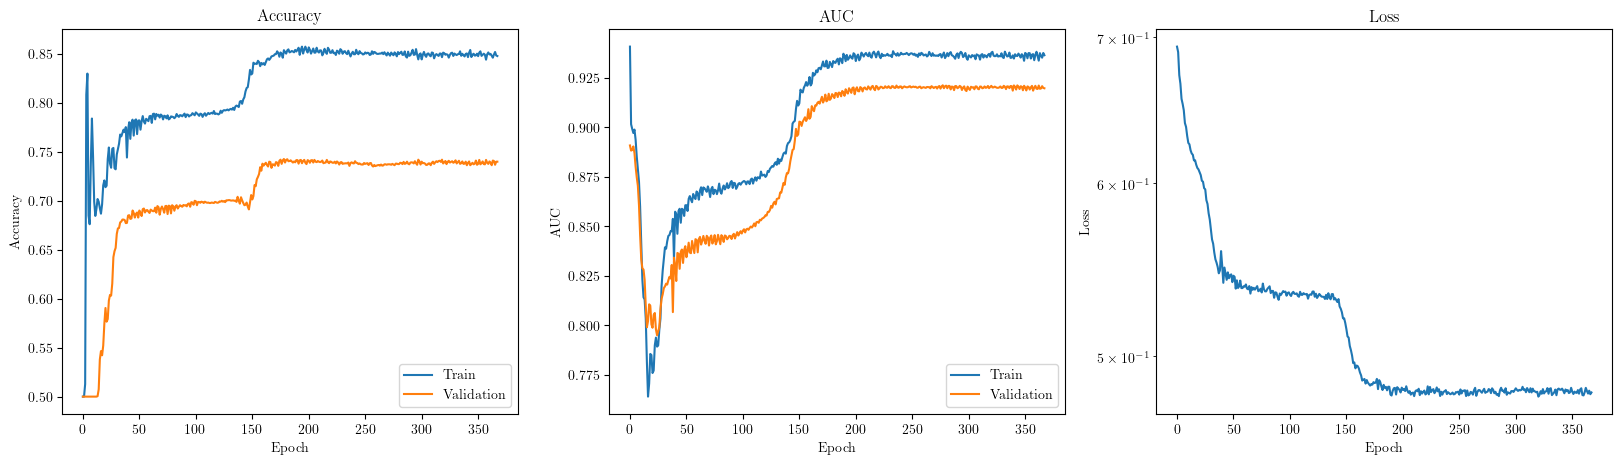

In [22]:
# Time series of the training
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(train_acc_history, label='Train')
ax[0].plot(val_acc_history, label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

ax[1].plot(train_auc_history, label='Train')
ax[1].plot(val_auc_history, label='Validation')
ax[1].set_title('AUC')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('AUC')

ax[2].plot(loss_history)
ax[2].set_title('Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_yscale('log')

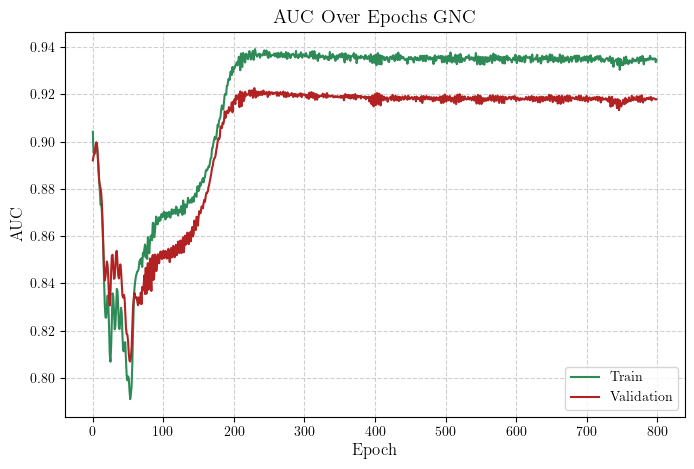

In [17]:
import matplotlib.pyplot as plt

# Creazione del grafico AUC con puntini più piccoli
plt.figure(figsize=(8, 5))
plt.plot(train_auc_history, label='Train', color='seagreen')
plt.plot(val_auc_history, label='Validation', color='firebrick')
plt.title('AUC Over Epochs GNC', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


(-0.075, 0.075)

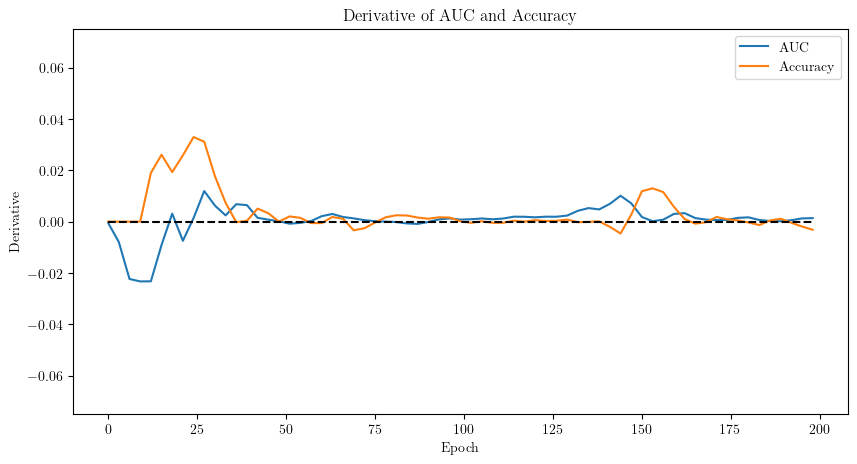

In [23]:
# Derivative of auc and accuracy
fig, ax = plt.subplots(figsize=(10, 5))

gradient_step = 3
x = np.arange(0, 200, gradient_step)
ax.plot(x, np.gradient(val_auc_history[:200:gradient_step]), label='AUC')
ax.plot(x, np.gradient(val_acc_history[:200:gradient_step]), label='Accuracy')
ax.plot(x, np.zeros((len(x))), 'k--')
ax.set_title('Derivative of AUC and Accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Derivative')
ax.set_ylim(-0.075, 0.075)

In [24]:
best_model = Net(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

Final Test AUC: 0.9126
Final Test ACC: 0.7269


### BEST AUC AND ACCURACY

In [26]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = Net(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = Net(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


  2%|▏         | 1/50 [00:20<16:32, 20.26s/it]

Early stopping at epoch 418.


  4%|▍         | 2/50 [00:30<11:23, 14.24s/it]

Early stopping at epoch 201.


  6%|▌         | 3/50 [00:50<13:12, 16.87s/it]

Early stopping at epoch 398.


  8%|▊         | 4/50 [01:12<14:41, 19.17s/it]

Early stopping at epoch 453.


 10%|█         | 5/50 [01:32<14:21, 19.15s/it]

Early stopping at epoch 379.


 12%|█▏        | 6/50 [01:52<14:27, 19.72s/it]

Early stopping at epoch 420.


 14%|█▍        | 7/50 [02:03<11:54, 16.61s/it]

Early stopping at epoch 201.


 16%|█▌        | 8/50 [02:23<12:23, 17.69s/it]

Early stopping at epoch 401.


 18%|█▊        | 9/50 [02:44<12:55, 18.90s/it]

Early stopping at epoch 429.


 20%|██        | 10/50 [02:54<10:42, 16.05s/it]

Early stopping at epoch 205.


 22%|██▏       | 11/50 [03:04<09:13, 14.19s/it]

Early stopping at epoch 201.


 24%|██▍       | 12/50 [03:14<08:13, 12.98s/it]

Early stopping at epoch 206.


 26%|██▌       | 13/50 [03:33<09:12, 14.93s/it]

Early stopping at epoch 402.


 28%|██▊       | 14/50 [03:50<09:11, 15.33s/it]

Early stopping at epoch 337.


 30%|███       | 15/50 [04:09<09:36, 16.48s/it]

Early stopping at epoch 395.


 32%|███▏      | 16/50 [04:27<09:41, 17.09s/it]

Early stopping at epoch 390.


 34%|███▍      | 17/50 [04:47<09:47, 17.79s/it]

Early stopping at epoch 397.


 36%|███▌      | 18/50 [05:07<09:56, 18.65s/it]

Early stopping at epoch 419.


 38%|███▊      | 19/50 [05:27<09:49, 19.01s/it]

Early stopping at epoch 398.


 40%|████      | 20/50 [05:48<09:42, 19.42s/it]

Early stopping at epoch 414.


 42%|████▏     | 21/50 [06:06<09:13, 19.07s/it]

Early stopping at epoch 379.


 44%|████▍     | 22/50 [06:16<07:37, 16.33s/it]

Early stopping at epoch 201.


 46%|████▌     | 23/50 [06:26<06:29, 14.42s/it]

Early stopping at epoch 201.


 48%|████▊     | 24/50 [06:36<05:39, 13.04s/it]

Early stopping at epoch 201.


 50%|█████     | 25/50 [06:55<06:10, 14.82s/it]

Early stopping at epoch 388.


 52%|█████▏    | 26/50 [07:15<06:32, 16.37s/it]

Early stopping at epoch 414.


 54%|█████▍    | 27/50 [07:25<05:32, 14.44s/it]

Early stopping at epoch 201.


 56%|█████▌    | 28/50 [07:46<06:02, 16.48s/it]

Early stopping at epoch 441.


 58%|█████▊    | 29/50 [08:06<06:09, 17.59s/it]

Early stopping at epoch 416.


 60%|██████    | 30/50 [08:26<06:03, 18.19s/it]

Early stopping at epoch 407.


 62%|██████▏   | 31/50 [08:44<05:45, 18.19s/it]

Early stopping at epoch 377.


 64%|██████▍   | 32/50 [09:03<05:35, 18.63s/it]

Early stopping at epoch 408.


 66%|██████▌   | 33/50 [09:24<05:28, 19.31s/it]

Early stopping at epoch 426.


 68%|██████▊   | 34/50 [09:34<04:23, 16.47s/it]

Early stopping at epoch 201.


 70%|███████   | 35/50 [09:44<03:38, 14.55s/it]

Early stopping at epoch 201.


 72%|███████▏  | 36/50 [09:54<03:05, 13.25s/it]

Early stopping at epoch 204.


 74%|███████▍  | 37/50 [10:15<03:22, 15.60s/it]

Early stopping at epoch 433.


 76%|███████▌  | 38/50 [10:25<02:45, 13.83s/it]

Early stopping at epoch 201.


 78%|███████▊  | 39/50 [10:43<02:46, 15.17s/it]

Early stopping at epoch 379.


 80%|████████  | 40/50 [11:02<02:41, 16.18s/it]

Early stopping at epoch 376.


 82%|████████▏ | 41/50 [11:21<02:33, 17.03s/it]

Early stopping at epoch 387.


 84%|████████▍ | 42/50 [11:31<01:59, 14.88s/it]

Early stopping at epoch 201.


 86%|████████▌ | 43/50 [11:52<01:56, 16.65s/it]

Early stopping at epoch 423.


 88%|████████▊ | 44/50 [12:11<01:45, 17.53s/it]

Early stopping at epoch 407.


 90%|█████████ | 45/50 [12:21<01:16, 15.22s/it]

Early stopping at epoch 201.


 92%|█████████▏| 46/50 [12:31<00:54, 13.59s/it]

Early stopping at epoch 201.


 94%|█████████▍| 47/50 [12:41<00:37, 12.53s/it]

Early stopping at epoch 201.


 96%|█████████▌| 48/50 [12:51<00:23, 11.74s/it]

Early stopping at epoch 201.


 98%|█████████▊| 49/50 [13:01<00:11, 11.16s/it]

Early stopping at epoch 201.


100%|██████████| 50/50 [13:20<00:00, 16.01s/it]

Early stopping at epoch 395.
Mean Test AUC: 0.8991 ± 0.0196
Mean Test ACC: 0.7168 ± 0.0119
The std of the test AUC is 0.0196
The std of the test ACC is 0.0119


## Training Curves Attention Model

In [21]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = Net(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=800, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1
    )

 37%|███▋      | 294/800 [00:15<00:25, 19.52it/s]

Early stopping at epoch 295.


In [26]:
# best model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = Net(dataset.num_features, 64, 32).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 68,832 trainable parameters


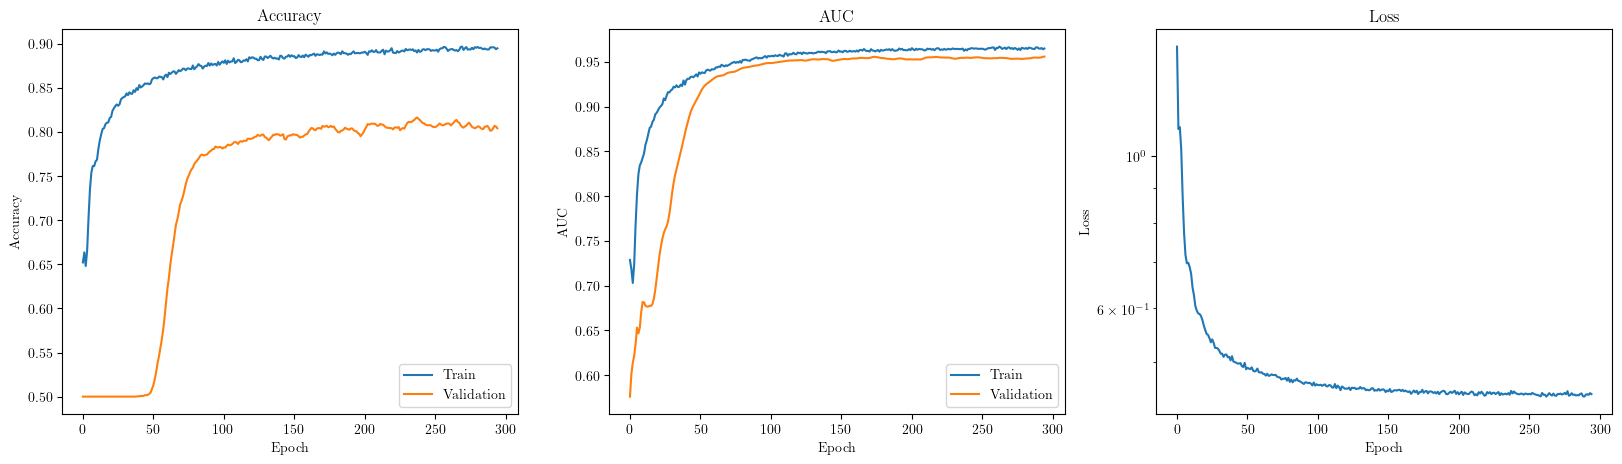

In [23]:
# Time series of the training
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(train_acc_history, label='Train')
ax[0].plot(val_acc_history, label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

ax[1].plot(train_auc_history, label='Train')
ax[1].plot(val_auc_history, label='Validation')
ax[1].set_title('AUC')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('AUC')

ax[2].plot(loss_history)
ax[2].set_title('Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_yscale('log')

(-0.075, 0.075)

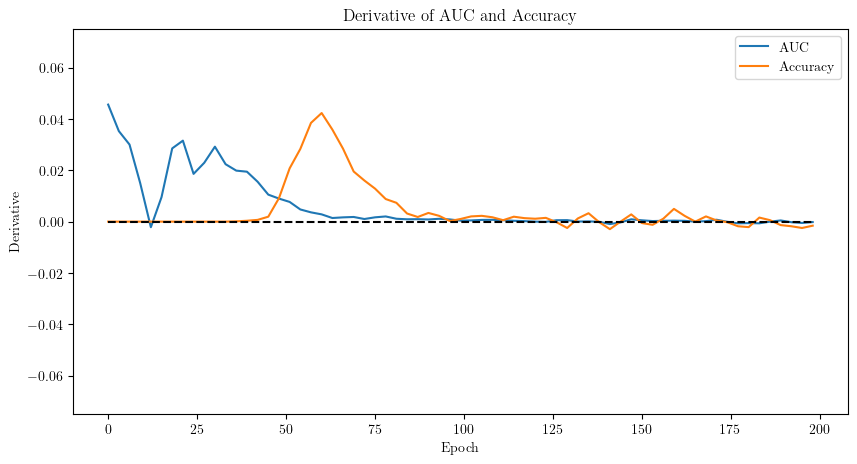

In [24]:
# Derivative of auc and accuracy
fig, ax = plt.subplots(figsize=(10, 5))

gradient_step = 3
x = np.arange(0, 200, gradient_step)
ax.plot(x, np.gradient(val_auc_history[:200:gradient_step]), label='AUC')
ax.plot(x, np.gradient(val_acc_history[:200:gradient_step]), label='Accuracy')
ax.plot(x, np.zeros((len(x))), 'k--')
ax.set_title('Derivative of AUC and Accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Derivative')
ax.set_ylim(-0.075, 0.075)

In [25]:
best_model = Net(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

Final Test AUC: 0.9533
Final Test ACC: 0.8099


### BEST AUC AND ACCURACY

In [27]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = Net(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=100,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = Net(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


  2%|▏         | 1/50 [00:10<08:28, 10.38s/it]

Early stopping at epoch 201.


  4%|▍         | 2/50 [00:21<08:30, 10.64s/it]

Early stopping at epoch 210.


  6%|▌         | 3/50 [00:31<08:05, 10.33s/it]

Early stopping at epoch 195.


  8%|▊         | 4/50 [00:42<08:19, 10.85s/it]

Early stopping at epoch 225.


 10%|█         | 5/50 [00:54<08:14, 10.98s/it]

Early stopping at epoch 218.


 12%|█▏        | 6/50 [01:05<08:04, 11.01s/it]

Early stopping at epoch 213.


 14%|█▍        | 7/50 [01:14<07:35, 10.60s/it]

Early stopping at epoch 190.


 16%|█▌        | 8/50 [01:26<07:37, 10.89s/it]

Early stopping at epoch 224.


 18%|█▊        | 9/50 [01:36<07:18, 10.69s/it]

Early stopping at epoch 201.


 20%|██        | 10/50 [01:50<07:41, 11.53s/it]

Early stopping at epoch 259.


 22%|██▏       | 11/50 [02:03<07:50, 12.06s/it]

Early stopping at epoch 257.


 24%|██▍       | 12/50 [02:16<07:46, 12.28s/it]

Early stopping at epoch 244.


 26%|██▌       | 13/50 [02:26<07:14, 11.75s/it]

Early stopping at epoch 204.


 28%|██▊       | 14/50 [02:37<06:58, 11.63s/it]

Early stopping at epoch 219.


 30%|███       | 15/50 [02:51<07:02, 12.08s/it]

Early stopping at epoch 256.


 32%|███▏      | 16/50 [03:02<06:43, 11.87s/it]

Early stopping at epoch 220.


 34%|███▍      | 17/50 [03:15<06:41, 12.16s/it]

Early stopping at epoch 250.


 36%|███▌      | 18/50 [03:27<06:25, 12.03s/it]

Early stopping at epoch 226.


 38%|███▊      | 19/50 [03:38<06:03, 11.73s/it]

Early stopping at epoch 216.


 40%|████      | 20/50 [03:49<05:46, 11.55s/it]

Early stopping at epoch 215.


 42%|████▏     | 21/50 [04:00<05:33, 11.52s/it]

Early stopping at epoch 223.


 44%|████▍     | 22/50 [04:12<05:28, 11.74s/it]

Early stopping at epoch 239.


 46%|████▌     | 23/50 [04:22<05:03, 11.24s/it]

Early stopping at epoch 195.


 48%|████▊     | 24/50 [04:33<04:48, 11.11s/it]

Early stopping at epoch 211.


 50%|█████     | 25/50 [04:44<04:32, 10.91s/it]

Early stopping at epoch 204.


 52%|█████▏    | 26/50 [04:54<04:20, 10.84s/it]

Early stopping at epoch 200.


 54%|█████▍    | 27/50 [05:06<04:13, 11.02s/it]

Early stopping at epoch 219.


 56%|█████▌    | 28/50 [05:16<03:59, 10.88s/it]

Early stopping at epoch 200.


 58%|█████▊    | 29/50 [05:26<03:41, 10.54s/it]

Early stopping at epoch 190.


 60%|██████    | 30/50 [05:36<03:26, 10.34s/it]

Early stopping at epoch 188.


 62%|██████▏   | 31/50 [05:47<03:18, 10.45s/it]

Early stopping at epoch 207.


 64%|██████▍   | 32/50 [05:58<03:15, 10.85s/it]

Early stopping at epoch 225.


 66%|██████▌   | 33/50 [06:12<03:15, 11.51s/it]

Early stopping at epoch 254.


 68%|██████▊   | 34/50 [06:26<03:16, 12.26s/it]

Early stopping at epoch 272.


 70%|███████   | 35/50 [06:37<03:01, 12.12s/it]

Early stopping at epoch 231.


 72%|███████▏  | 36/50 [06:51<02:56, 12.63s/it]

Early stopping at epoch 267.


 74%|███████▍  | 37/50 [07:02<02:38, 12.18s/it]

Early stopping at epoch 217.


 76%|███████▌  | 38/50 [07:13<02:19, 11.66s/it]

Early stopping at epoch 202.


 78%|███████▊  | 39/50 [07:22<02:01, 11.04s/it]

Early stopping at epoch 186.


 80%|████████  | 40/50 [07:33<01:50, 11.04s/it]

Early stopping at epoch 214.


 82%|████████▏ | 41/50 [07:46<01:43, 11.45s/it]

Early stopping at epoch 243.


 84%|████████▍ | 42/50 [07:56<01:27, 10.99s/it]

Early stopping at epoch 193.


 86%|████████▌ | 43/50 [08:06<01:15, 10.75s/it]

Early stopping at epoch 199.


 88%|████████▊ | 44/50 [08:18<01:06, 11.04s/it]

Early stopping at epoch 227.


 90%|█████████ | 45/50 [08:31<00:58, 11.78s/it]

Early stopping at epoch 264.


 92%|█████████▏| 46/50 [08:41<00:45, 11.27s/it]

Early stopping at epoch 194.


 94%|█████████▍| 47/50 [08:55<00:36, 12.16s/it]

Early stopping at epoch 277.


 96%|█████████▌| 48/50 [09:06<00:23, 11.75s/it]

Early stopping at epoch 209.


 98%|█████████▊| 49/50 [09:20<00:12, 12.23s/it]

Early stopping at epoch 259.


100%|██████████| 50/50 [09:31<00:00, 11.42s/it]

Early stopping at epoch 214.
Mean Test AUC: 0.9519 ± 0.0012
Mean Test ACC: 0.8065 ± 0.0050
The std of the test AUC is 0.0012
The std of the test ACC is 0.0050


## Training Curves Recurrent Layer Model

In [22]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = Net(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=800, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1
    )

 34%|███▍      | 272/800 [00:24<00:47, 11.03it/s]

Early stopping at epoch 273.


In [27]:
# best model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = Net(dataset.num_features, 64, 32).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 53,152 trainable parameters


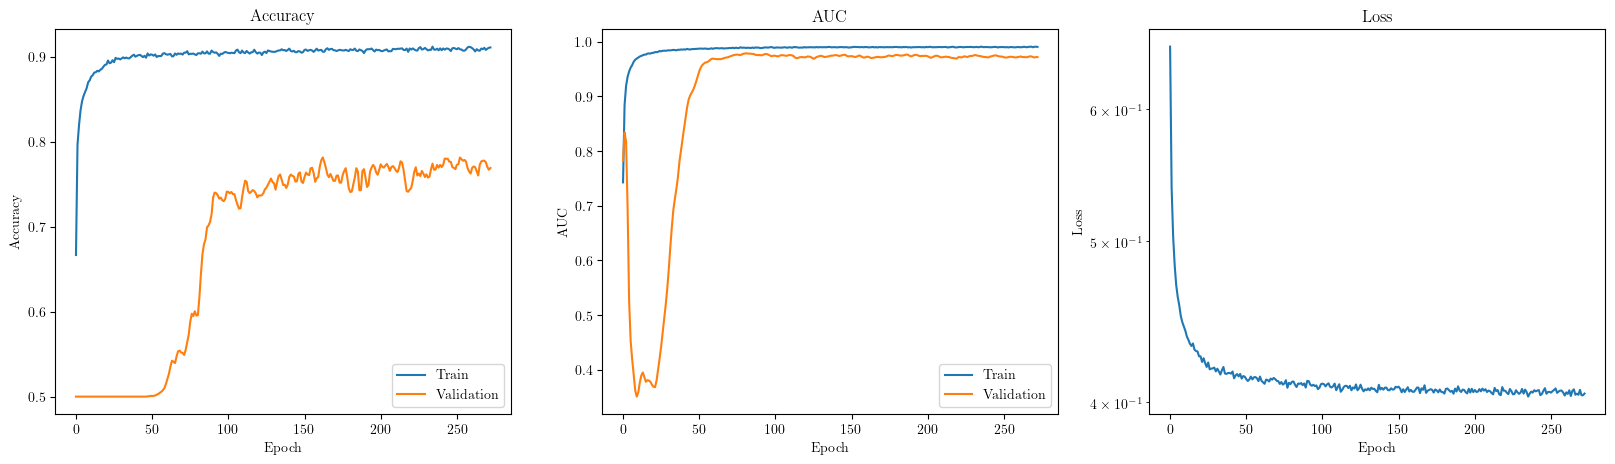

In [24]:
# Time series of the training
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(train_acc_history, label='Train')
ax[0].plot(val_acc_history, label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

ax[1].plot(train_auc_history, label='Train')
ax[1].plot(val_auc_history, label='Validation')
ax[1].set_title('AUC')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('AUC')

ax[2].plot(loss_history)
ax[2].set_title('Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_yscale('log')

(-0.075, 0.075)

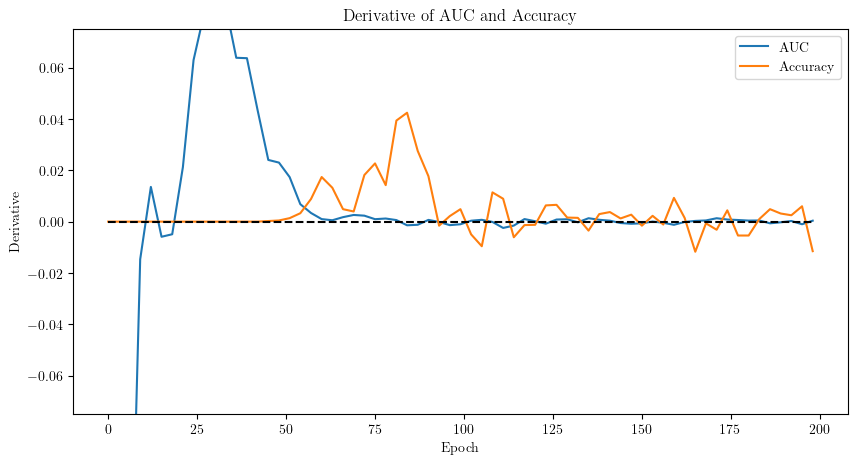

In [25]:
# Derivative of auc and accuracy
fig, ax = plt.subplots(figsize=(10, 5))

gradient_step = 3
x = np.arange(0, 200, gradient_step)
ax.plot(x, np.gradient(val_auc_history[:200:gradient_step]), label='AUC')
ax.plot(x, np.gradient(val_acc_history[:200:gradient_step]), label='Accuracy')
ax.plot(x, np.zeros((len(x))), 'k--')
ax.set_title('Derivative of AUC and Accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Derivative')
ax.set_ylim(-0.075, 0.075)

In [26]:
best_model = Net(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

Final Test AUC: 0.9744
Final Test ACC: 0.7809


### BEST AUC AND ACCURACY

In [28]:
test_acc, test_auc, test_mrr = [], [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = Net(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=True
        )
    best_model = Net(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


  2%|▏         | 1/50 [00:26<21:15, 26.03s/it]

Early stopping at epoch 284.


  4%|▍         | 2/50 [00:52<20:49, 26.03s/it]

Early stopping at epoch 284.


  6%|▌         | 3/50 [01:16<19:50, 25.33s/it]

Early stopping at epoch 267.


  8%|▊         | 4/50 [01:41<19:19, 25.20s/it]

Early stopping at epoch 272.


 10%|█         | 5/50 [02:07<19:01, 25.36s/it]

Early stopping at epoch 279.


 12%|█▏        | 6/50 [02:32<18:32, 25.28s/it]

Early stopping at epoch 272.


 14%|█▍        | 7/50 [02:57<18:06, 25.28s/it]

Early stopping at epoch 278.


 16%|█▌        | 8/50 [03:24<17:58, 25.67s/it]

Early stopping at epoch 294.


 18%|█▊        | 9/50 [03:48<17:15, 25.26s/it]

Early stopping at epoch 269.


 20%|██        | 10/50 [04:12<16:40, 25.01s/it]

Early stopping at epoch 266.


 22%|██▏       | 11/50 [04:36<16:04, 24.72s/it]

Early stopping at epoch 264.


 24%|██▍       | 12/50 [05:00<15:28, 24.44s/it]

Early stopping at epoch 259.


 26%|██▌       | 13/50 [05:24<14:58, 24.29s/it]

Early stopping at epoch 263.


 28%|██▊       | 14/50 [05:48<14:33, 24.26s/it]

Early stopping at epoch 264.


 30%|███       | 15/50 [06:14<14:22, 24.64s/it]

Early stopping at epoch 279.


 32%|███▏      | 16/50 [06:38<13:49, 24.40s/it]

Early stopping at epoch 258.


 34%|███▍      | 17/50 [07:02<13:22, 24.32s/it]

Early stopping at epoch 264.


 36%|███▌      | 18/50 [07:28<13:14, 24.84s/it]

Early stopping at epoch 286.


 38%|███▊      | 19/50 [07:52<12:43, 24.63s/it]

Early stopping at epoch 265.


 40%|████      | 20/50 [08:17<12:19, 24.63s/it]

Early stopping at epoch 269.


 42%|████▏     | 21/50 [08:41<11:51, 24.54s/it]

Early stopping at epoch 270.


 44%|████▍     | 22/50 [09:06<11:31, 24.68s/it]

Early stopping at epoch 276.


 46%|████▌     | 23/50 [09:31<11:09, 24.80s/it]

Early stopping at epoch 280.


 48%|████▊     | 24/50 [09:56<10:41, 24.69s/it]

Early stopping at epoch 271.


 50%|█████     | 25/50 [10:20<10:13, 24.54s/it]

Early stopping at epoch 270.


 52%|█████▏    | 26/50 [10:43<09:39, 24.16s/it]

Early stopping at epoch 259.


 54%|█████▍    | 27/50 [11:06<09:09, 23.91s/it]

Early stopping at epoch 260.


 56%|█████▌    | 28/50 [11:30<08:45, 23.88s/it]

Early stopping at epoch 264.


 58%|█████▊    | 29/50 [11:54<08:22, 23.92s/it]

Early stopping at epoch 263.


 60%|██████    | 30/50 [12:19<08:02, 24.13s/it]

Early stopping at epoch 268.


 62%|██████▏   | 31/50 [12:46<07:56, 25.07s/it]

Early stopping at epoch 302.


 64%|██████▍   | 32/50 [13:11<07:29, 24.95s/it]

Early stopping at epoch 270.


 66%|██████▌   | 33/50 [13:37<07:08, 25.22s/it]

Early stopping at epoch 279.


 68%|██████▊   | 34/50 [14:01<06:39, 25.00s/it]

Early stopping at epoch 267.


 70%|███████   | 35/50 [14:26<06:12, 24.86s/it]

Early stopping at epoch 265.


 72%|███████▏  | 36/50 [14:51<05:50, 25.02s/it]

Early stopping at epoch 277.


 74%|███████▍  | 37/50 [15:15<05:21, 24.75s/it]

Early stopping at epoch 264.


 76%|███████▌  | 38/50 [15:39<04:55, 24.59s/it]

Early stopping at epoch 264.


 78%|███████▊  | 39/50 [16:04<04:29, 24.50s/it]

Early stopping at epoch 269.


 80%|████████  | 40/50 [16:30<04:09, 24.96s/it]

Early stopping at epoch 278.


 82%|████████▏ | 41/50 [16:53<03:40, 24.55s/it]

Early stopping at epoch 259.


 84%|████████▍ | 42/50 [17:18<03:16, 24.51s/it]

Early stopping at epoch 266.


 86%|████████▌ | 43/50 [17:45<02:57, 25.29s/it]

Early stopping at epoch 291.


 88%|████████▊ | 44/50 [18:11<02:33, 25.52s/it]

Early stopping at epoch 284.


 90%|█████████ | 45/50 [18:36<02:06, 25.27s/it]

Early stopping at epoch 273.


 92%|█████████▏| 46/50 [19:00<01:40, 25.05s/it]

Early stopping at epoch 268.


 94%|█████████▍| 47/50 [19:25<01:15, 25.04s/it]

Early stopping at epoch 275.


 96%|█████████▌| 48/50 [19:49<00:49, 24.74s/it]

Early stopping at epoch 261.


 98%|█████████▊| 49/50 [20:14<00:24, 24.77s/it]

Early stopping at epoch 270.


100%|██████████| 50/50 [20:39<00:00, 24.79s/it]

Early stopping at epoch 270.
Mean Test AUC: 0.9736 ± 0.0014
Mean Test ACC: 0.7749 ± 0.0097
The std of the test AUC is 0.0014
The std of the test ACC is 0.0097


## Training Curves VAE

In [21]:
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 128       # Number of hidden channels
out_channels = 64           # Number of output features

# Create the model instance (Variational Autoencoder)
model = Net(in_channels, hidden_channels, out_channels).to(device)

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Initialize the trainer
trainer = GCNTrainer(model=model, optimizer=optimizer, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
    train_data=train_data, 
    val_data=val_data, 
    epochs=800, 
    early_stopping=True, 
    early_stopping_patience=200,
    
)

  0%|          | 0/800 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([19717, 500])) must be the same as input size (torch.Size([37676]))

In [ ]:
# best model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = Net(dataset.num_features, 128, 64).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

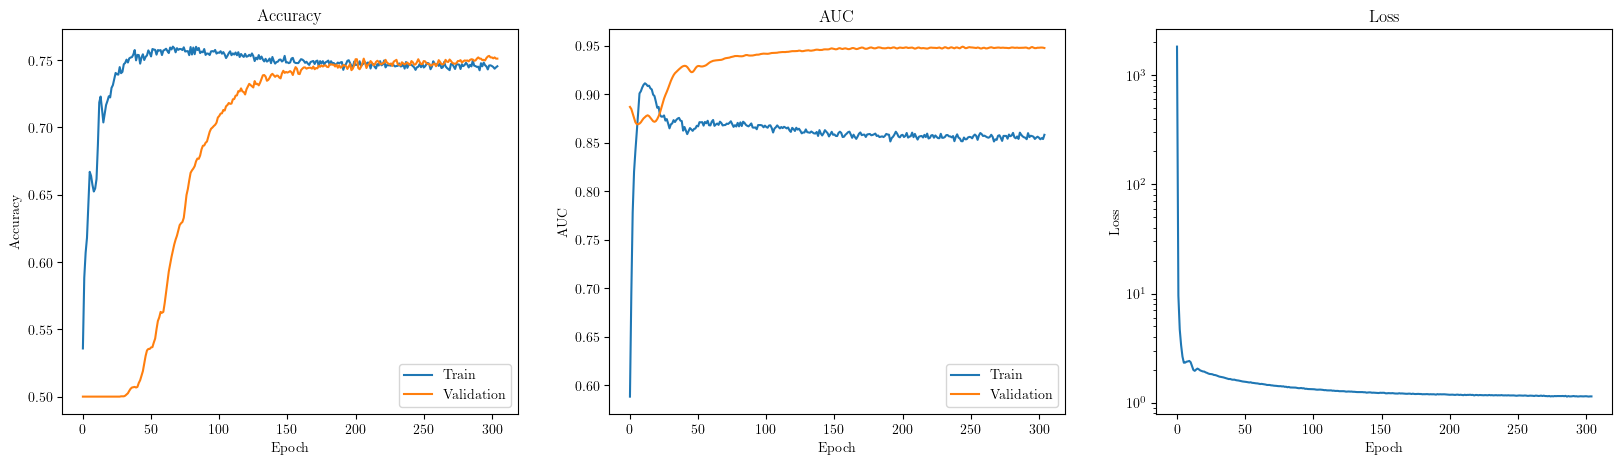

In [30]:
# Time series of the training
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(train_acc_history, label='Train')
ax[0].plot(val_acc_history, label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

ax[1].plot(train_auc_history, label='Train')
ax[1].plot(val_auc_history, label='Validation')
ax[1].set_title('AUC')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('AUC')

ax[2].plot(loss_history)
ax[2].set_title('Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_yscale('log')

(-0.075, 0.075)

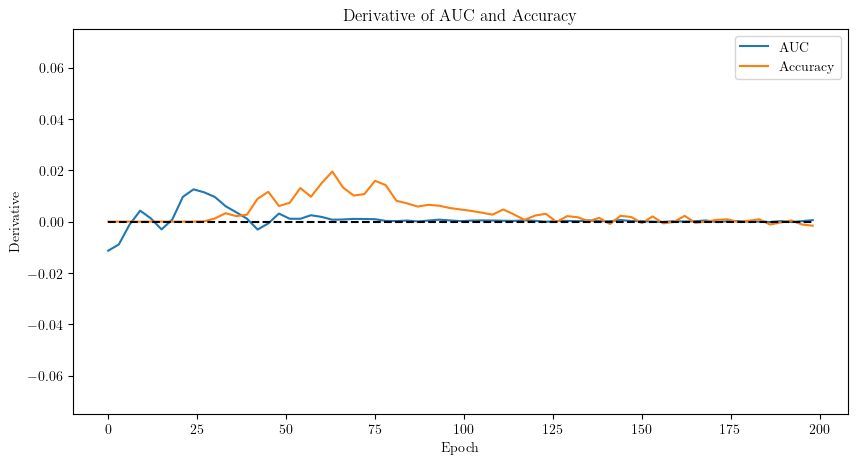

In [31]:
# Derivative of auc and accuracy
fig, ax = plt.subplots(figsize=(10, 5))

gradient_step = 3
x = np.arange(0, 200, gradient_step)
ax.plot(x, np.gradient(val_auc_history[:200:gradient_step]), label='AUC')
ax.plot(x, np.gradient(val_acc_history[:200:gradient_step]), label='Accuracy')
ax.plot(x, np.zeros((len(x))), 'k--')
ax.set_title('Derivative of AUC and Accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Derivative')
ax.set_ylim(-0.075, 0.075)

In [32]:
# Load the best model's weights into a new model instance for testing
best_model = Net(in_channels, hidden_channels, out_channels).to(device)
trainer.duplicate_best_model_weights(best_model, f'best_model_{run_timestamp}.pth')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')


Final Test AUC: 0.9481
Final Test ACC: 0.7482


### BEST AUC AND ACCURACY

In [ ]:
test_acc, test_auc, test_mrr = [], [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 128 # Number of hidden channels
    out_channels = 64 # Number of output features

    # Create the model instance
    model = Net(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=100,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=True
        )
    best_model = Net(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


## Training Curves New Model (dropout and batch normalization)

In [40]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = Net(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=800, 
        early_stopping=False, 
        early_stopping_patience=100,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=True
    )

100%|██████████| 800/800 [00:38<00:00, 20.57it/s]

Total training time: 33.1062 seconds.
Total validation time: 4.1816 seconds.


In [41]:
# best model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = Net(dataset.num_features, 64, 32).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,336 trainable parameters


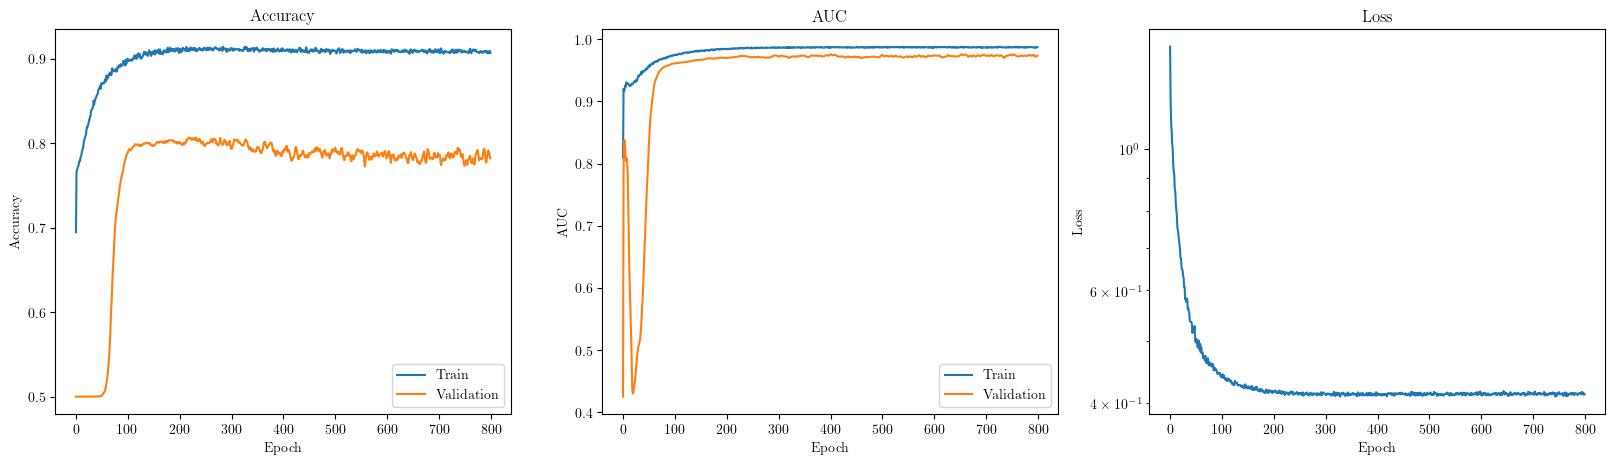

In [42]:
# Time series of the training
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(train_acc_history, label='Train')
ax[0].plot(val_acc_history, label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

ax[1].plot(train_auc_history, label='Train')
ax[1].plot(val_auc_history, label='Validation')
ax[1].set_title('AUC')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('AUC')


ax[2].plot(loss_history)
ax[2].set_title('Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_yscale('log')

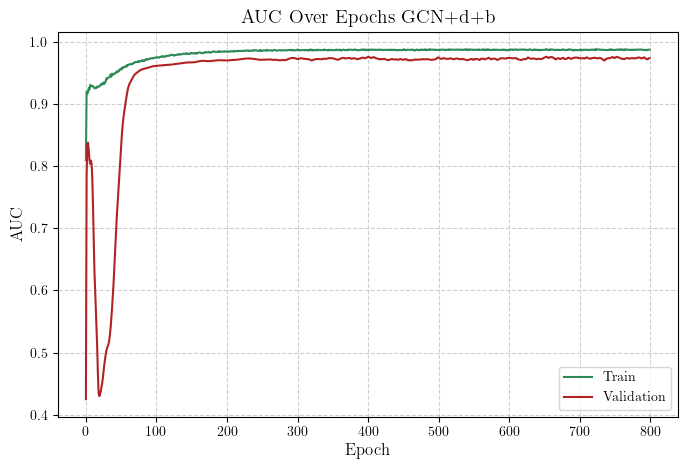

In [49]:
# Creazione del grafico AUC con puntini più piccoli
plt.figure(figsize=(8, 5))
plt.plot(train_auc_history, label='Train', color='seagreen')
plt.plot(val_auc_history, label='Validation', color='firebrick')
plt.title('AUC Over Epochs GCN+d+b', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


(-0.075, 0.075)

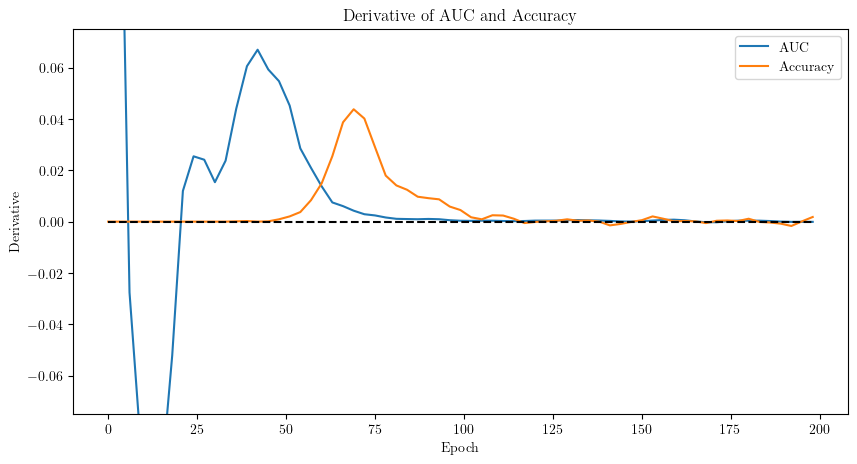

In [43]:
# Derivative of auc and accuracy
fig, ax = plt.subplots(figsize=(10, 5))

gradient_step = 3
x = np.arange(0, 200, gradient_step)
ax.plot(x, np.gradient(val_auc_history[:200:gradient_step]), label='AUC')
ax.plot(x, np.gradient(val_acc_history[:200:gradient_step]), label='Accuracy')
ax.plot(x, np.zeros((len(x))), 'k--')
ax.set_title('Derivative of AUC and Accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Derivative')
ax.set_ylim(-0.075, 0.075)

In [24]:
best_model = Net(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')


Final Test AUC: 0.9736
Final Test ACC: 0.7960


### BEST AUC AND ACCURACY

In [25]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = Net(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = Net(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


  2%|▏         | 1/50 [00:14<11:37, 14.23s/it]

Early stopping at epoch 308.


  4%|▍         | 2/50 [00:35<14:41, 18.37s/it]

Early stopping at epoch 465.


  6%|▌         | 3/50 [00:49<12:56, 16.51s/it]

Early stopping at epoch 311.


  8%|▊         | 4/50 [01:05<12:28, 16.27s/it]

Early stopping at epoch 320.


 10%|█         | 5/50 [01:23<12:39, 16.88s/it]

Early stopping at epoch 371.


 12%|█▏        | 6/50 [01:45<13:31, 18.44s/it]

Early stopping at epoch 423.


 14%|█▍        | 7/50 [02:04<13:31, 18.87s/it]

Early stopping at epoch 417.


 16%|█▌        | 8/50 [02:20<12:28, 17.82s/it]

Early stopping at epoch 331.


 18%|█▊        | 9/50 [02:44<13:30, 19.78s/it]

Early stopping at epoch 506.


 20%|██        | 10/50 [02:59<12:11, 18.29s/it]

Early stopping at epoch 296.


 22%|██▏       | 11/50 [03:13<11:04, 17.03s/it]

Early stopping at epoch 299.


 24%|██▍       | 12/50 [03:29<10:31, 16.61s/it]

Early stopping at epoch 330.


 26%|██▌       | 13/50 [03:47<10:30, 17.05s/it]

Early stopping at epoch 381.


 28%|██▊       | 14/50 [04:02<09:54, 16.51s/it]

Early stopping at epoch 333.


 30%|███       | 15/50 [04:22<10:07, 17.37s/it]

Early stopping at epoch 403.


 32%|███▏      | 16/50 [04:40<10:00, 17.66s/it]

Early stopping at epoch 367.


 34%|███▍      | 17/50 [04:59<09:56, 18.07s/it]

Early stopping at epoch 379.


 36%|███▌      | 18/50 [05:18<09:53, 18.53s/it]

Early stopping at epoch 390.


 38%|███▊      | 19/50 [05:37<09:31, 18.43s/it]

Early stopping at epoch 385.


 40%|████      | 20/50 [05:53<08:51, 17.72s/it]

Early stopping at epoch 333.


 42%|████▏     | 21/50 [06:11<08:36, 17.82s/it]

Early stopping at epoch 375.


 44%|████▍     | 22/50 [06:26<08:00, 17.15s/it]

Early stopping at epoch 310.


 46%|████▌     | 23/50 [06:42<07:31, 16.72s/it]

Early stopping at epoch 338.


 48%|████▊     | 24/50 [07:03<07:43, 17.83s/it]

Early stopping at epoch 406.


 50%|█████     | 25/50 [07:19<07:13, 17.35s/it]

Early stopping at epoch 323.


 52%|█████▏    | 26/50 [07:35<06:47, 16.96s/it]

Early stopping at epoch 316.


 54%|█████▍    | 27/50 [07:58<07:16, 18.98s/it]

Early stopping at epoch 472.


 56%|█████▌    | 28/50 [08:19<07:05, 19.35s/it]

Early stopping at epoch 401.


 58%|█████▊    | 29/50 [08:38<06:47, 19.40s/it]

Early stopping at epoch 390.


 60%|██████    | 30/50 [08:55<06:10, 18.52s/it]

Early stopping at epoch 326.


 62%|██████▏   | 31/50 [09:17<06:11, 19.54s/it]

Early stopping at epoch 437.


 64%|██████▍   | 32/50 [09:38<05:59, 19.99s/it]

Early stopping at epoch 424.


 66%|██████▌   | 33/50 [09:58<05:43, 20.22s/it]

Early stopping at epoch 420.


 68%|██████▊   | 34/50 [10:15<05:04, 19.06s/it]

Early stopping at epoch 322.


 70%|███████   | 35/50 [10:31<04:31, 18.10s/it]

Early stopping at epoch 322.


 72%|███████▏  | 36/50 [10:48<04:11, 17.97s/it]

Early stopping at epoch 384.


 74%|███████▍  | 37/50 [11:08<04:01, 18.59s/it]

Early stopping at epoch 413.


 76%|███████▌  | 38/50 [11:27<03:42, 18.54s/it]

Early stopping at epoch 365.


 78%|███████▊  | 39/50 [11:45<03:22, 18.39s/it]

Early stopping at epoch 358.


 80%|████████  | 40/50 [12:00<02:55, 17.59s/it]

Early stopping at epoch 313.


 82%|████████▏ | 41/50 [12:20<02:42, 18.08s/it]

Early stopping at epoch 383.


 84%|████████▍ | 42/50 [12:43<02:37, 19.63s/it]

Early stopping at epoch 460.


 86%|████████▌ | 43/50 [13:03<02:17, 19.66s/it]

Early stopping at epoch 396.


 88%|████████▊ | 44/50 [13:20<01:52, 18.82s/it]

Early stopping at epoch 334.


 90%|█████████ | 45/50 [13:43<01:40, 20.19s/it]

Early stopping at epoch 466.


 92%|█████████▏| 46/50 [14:03<01:20, 20.13s/it]

Early stopping at epoch 416.


 94%|█████████▍| 47/50 [14:20<00:57, 19.12s/it]

Early stopping at epoch 336.


 96%|█████████▌| 48/50 [14:36<00:36, 18.27s/it]

Early stopping at epoch 324.


 98%|█████████▊| 49/50 [14:58<00:19, 19.30s/it]

Early stopping at epoch 435.


100%|██████████| 50/50 [15:16<00:00, 18.33s/it]

Early stopping at epoch 384.
Mean Test AUC: 0.9755 ± 0.0009
Mean Test ACC: 0.7892 ± 0.0040
The std of the test AUC is 0.0009
The std of the test ACC is 0.0040


## Percentage of training data

In [16]:
# Define percentages
percentages = np.linspace(0.1, 0.9, 9)

# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

for i in percentages:
    auc_scores = []
    acc_scores = []
    
    for _ in range(5): 
        transform = T.Compose([
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=1 - 0.05 - i, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        
        dataset = Planetoid("./nets/", name='PubMed', transform=transform)
        train_data, val_data, test_data = dataset[0]
        
        
        model = Net(dataset.num_features, 64, 32).to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and get results
        # Assicurati di passare g_val e g_test alla funzione train_model
        _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=800, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1 
    )
        best_model = Net(dataset.num_features, 64, 32).to(device)
        best_model.load_state_dict(trainer.best_model_state_dict)
        final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)

        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)
    
    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))

 62%|██████▏   | 495/800 [00:07<00:04, 67.08it/s]


Early stopping at epoch 496.


 62%|██████▏   | 492/800 [00:06<00:04, 76.09it/s]


Early stopping at epoch 493.


 59%|█████▉    | 470/800 [00:06<00:04, 72.52it/s]


Early stopping at epoch 471.


 66%|██████▌   | 526/800 [00:07<00:04, 68.26it/s]


Early stopping at epoch 527.


 48%|████▊     | 385/800 [00:05<00:05, 76.70it/s]


Early stopping at epoch 386.


 52%|█████▏    | 417/800 [00:07<00:06, 57.61it/s]


Early stopping at epoch 418.


 52%|█████▏    | 412/800 [00:07<00:06, 57.83it/s]


Early stopping at epoch 413.


 48%|████▊     | 380/800 [00:06<00:07, 56.86it/s]


Early stopping at epoch 381.


 51%|█████▏    | 410/800 [00:06<00:06, 59.45it/s]


Early stopping at epoch 411.


 48%|████▊     | 385/800 [00:06<00:07, 57.43it/s]


Early stopping at epoch 386.


 63%|██████▎   | 503/800 [00:11<00:06, 44.40it/s]


Early stopping at epoch 504.


 43%|████▎     | 343/800 [00:07<00:10, 44.89it/s]


Early stopping at epoch 344.


 52%|█████▏    | 419/800 [00:09<00:08, 44.68it/s]


Early stopping at epoch 420.


 52%|█████▏    | 417/800 [00:08<00:08, 47.51it/s]


Early stopping at epoch 418.


 62%|██████▏   | 492/800 [00:10<00:06, 45.79it/s]


Early stopping at epoch 493.


 47%|████▋     | 379/800 [00:10<00:11, 37.23it/s]


Early stopping at epoch 380.


 42%|████▏     | 333/800 [00:09<00:12, 36.86it/s]


Early stopping at epoch 334.


 42%|████▏     | 337/800 [00:08<00:12, 37.90it/s]


Early stopping at epoch 338.


 43%|████▎     | 344/800 [00:09<00:12, 36.99it/s]


Early stopping at epoch 345.


 65%|██████▍   | 519/800 [00:12<00:06, 40.54it/s]


Early stopping at epoch 520.


 44%|████▍     | 352/800 [00:10<00:13, 33.30it/s]


Early stopping at epoch 353.


 43%|████▎     | 341/800 [00:11<00:15, 30.26it/s]


Early stopping at epoch 342.


 42%|████▏     | 334/800 [00:11<00:15, 30.35it/s]


Early stopping at epoch 335.


 46%|████▌     | 364/800 [00:12<00:14, 29.97it/s]


Early stopping at epoch 365.


 48%|████▊     | 383/800 [00:12<00:13, 30.04it/s]


Early stopping at epoch 384.


 46%|████▋     | 370/800 [00:13<00:15, 27.67it/s]


Early stopping at epoch 371.


 39%|███▉      | 313/800 [00:11<00:17, 27.45it/s]


Early stopping at epoch 314.


 40%|████      | 323/800 [00:11<00:16, 28.14it/s]


Early stopping at epoch 324.


 44%|████▍     | 355/800 [00:12<00:15, 27.97it/s]


Early stopping at epoch 356.


 42%|████▏     | 337/800 [00:11<00:15, 29.24it/s]


Early stopping at epoch 338.


 58%|█████▊    | 464/800 [00:18<00:13, 24.46it/s]


Early stopping at epoch 465.


 44%|████▍     | 351/800 [00:14<00:18, 24.18it/s]


Early stopping at epoch 352.


 53%|█████▎    | 422/800 [00:16<00:15, 24.89it/s]


Early stopping at epoch 423.


 49%|████▉     | 394/800 [00:15<00:16, 25.16it/s]


Early stopping at epoch 395.


 63%|██████▎   | 503/800 [00:20<00:11, 25.08it/s]


Early stopping at epoch 504.


 47%|████▋     | 379/800 [00:17<00:18, 22.17it/s]


Early stopping at epoch 380.


 53%|█████▎    | 426/800 [00:19<00:16, 22.29it/s]


Early stopping at epoch 427.


 39%|███▉      | 314/800 [00:13<00:21, 23.05it/s]


Early stopping at epoch 315.


 45%|████▌     | 362/800 [00:17<00:20, 20.99it/s]


Early stopping at epoch 363.


 39%|███▉      | 313/800 [00:14<00:23, 20.93it/s]


Early stopping at epoch 314.


 62%|██████▏   | 494/800 [00:24<00:15, 20.19it/s]


Early stopping at epoch 495.


 40%|███▉      | 316/800 [00:16<00:24, 19.52it/s]


Early stopping at epoch 317.


 49%|████▉     | 393/800 [00:19<00:20, 19.87it/s]


Early stopping at epoch 394.


 46%|████▌     | 367/800 [00:18<00:21, 19.69it/s]


Early stopping at epoch 368.


 60%|██████    | 481/800 [00:24<00:16, 19.71it/s]

Early stopping at epoch 482.


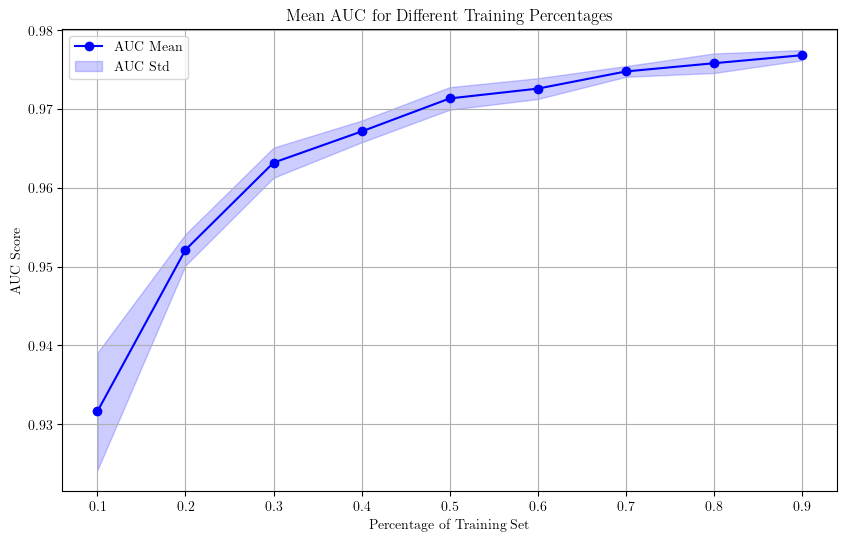

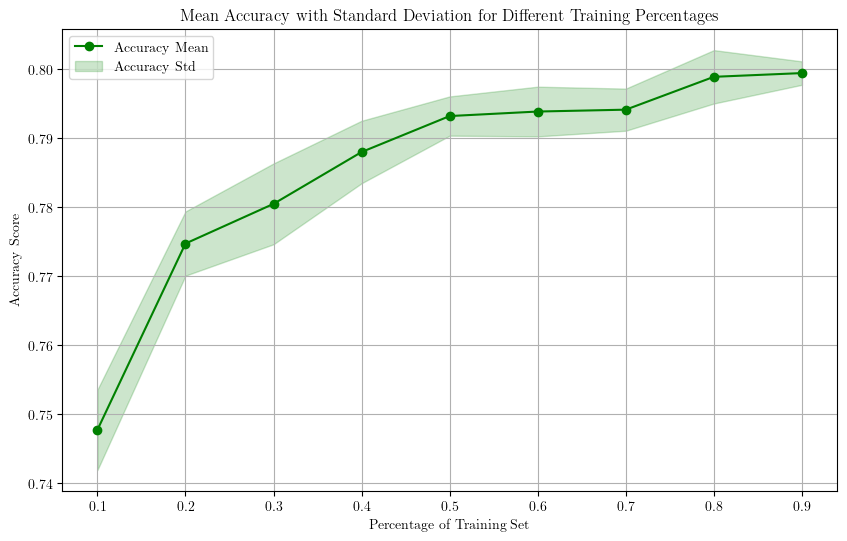

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0.2, label='AUC Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('AUC Score')
plt.title('Mean AUC for Different Training Percentages')
plt.grid(True)
plt.legend()

# Plotting Accuracy results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_acc_mean, label='Accuracy Mean', color='green', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std),
                 np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std),
                 color='green', alpha=0.2, label='Accuracy Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('Accuracy Score')
plt.title('Mean Accuracy with Standard Deviation for Different Training Percentages')
plt.grid(True)
plt.legend()

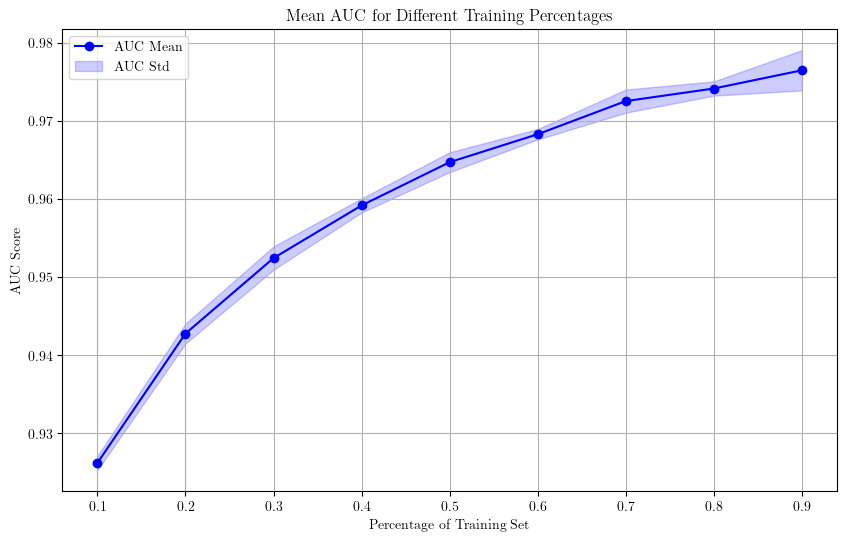

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0.2, label='AUC Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('AUC Score')
plt.title('Mean AUC for Different Training Percentages')
plt.grid(True)
plt.legend()

In [18]:
# Save results, model structure, and percentages to a pickle file
results = {
    'test_accuracy_auc_mean': test_accuracy_auc_mean,
    'test_accuracy_auc_std': test_accuracy_auc_std,
    'test_accuracy_acc_mean': test_accuracy_acc_mean,
    'test_accuracy_acc_std': test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': percentages.tolist()  # Convert numpy array to list for serialization
}

with open('results_and_model_class.pkl', 'wb') as f:
    pickle.dump(results, f)

## Percentage of the features

In [19]:
# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

# Define percentages of features to use
feature_percentages = np.linspace(0.1, 0.9, 9)  # e.g., 10%, 20%, ..., 90% of features

# Fixed train, validation, and test split once
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,  # Fixed sizes
                      add_negative_train_samples=False),
])

dataset = Planetoid("./nets/", name='PubMed', transform=transform)
train_data, val_data, test_data = dataset[0]

# Original number of features
num_features = train_data.x.size(1)  # Assuming `x` is the node feature matrix (N x F)
for perc in feature_percentages:
    auc_scores = []
    acc_scores = []

    # Determine the number of features to use for this percentage
    num_features_to_use = min(int(perc * num_features), num_features)  # Ensure it does not exceed actual number of features

    for _ in range(5):  # Repeat 5 times to average
        # Shuffle and select a percentage of features
        selected_features_idx = np.random.permutation(num_features)[:num_features_to_use]


        
        # Create copies of the data and apply the selected features to the dataset
        train_data_copy = train_data.clone()
        val_data_copy = val_data.clone()
        test_data_copy = test_data.clone()

        # Apply the selected features to the dataset
        train_data_copy.x = train_data_copy.x[:, selected_features_idx]
        val_data_copy.x = val_data_copy.x[:, selected_features_idx]
        test_data_copy.x = test_data_copy.x[:, selected_features_idx]

        # Initialize model, optimizer, and criterion
        model = Net(num_features_to_use, 64, 32).to(device)  # Update input size
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and evaluate
        _, _, _, _, _, run_timestamp = trainer.train_model(
            train_data=train_data_copy,
            val_data=val_data_copy,
            epochs=800,
            early_stopping=True,
            early_stopping_patience=100,
        )
        best_model = Net(num_features_to_use, 64, 32).to(device)
        best_model.load_state_dict(trainer.best_model_state_dict)
        final_test_acc, final_test_auc = trainer.test(test_data_copy)
        
        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)

    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))


 22%|██▏       | 177/800 [00:08<00:30, 20.16it/s]


Early stopping at epoch 178.


 28%|██▊       | 225/800 [00:11<00:28, 19.93it/s]


Early stopping at epoch 226.


 31%|███       | 249/800 [00:12<00:27, 19.94it/s]


Early stopping at epoch 250.


 29%|██▉       | 232/800 [00:10<00:25, 22.08it/s]


Early stopping at epoch 233.


 21%|██▏       | 171/800 [00:07<00:28, 22.05it/s]


Early stopping at epoch 172.


 27%|██▋       | 219/800 [00:10<00:27, 21.14it/s]


Early stopping at epoch 220.


 28%|██▊       | 222/800 [00:10<00:26, 22.05it/s]


Early stopping at epoch 223.


 31%|███       | 246/800 [00:11<00:26, 21.02it/s]


Early stopping at epoch 247.


 23%|██▎       | 184/800 [00:09<00:31, 19.64it/s]


Early stopping at epoch 185.


 23%|██▎       | 187/800 [00:08<00:29, 20.92it/s]


Early stopping at epoch 188.


 27%|██▋       | 218/800 [00:10<00:28, 20.77it/s]


Early stopping at epoch 219.


 28%|██▊       | 223/800 [00:11<00:28, 20.02it/s]


Early stopping at epoch 224.


 33%|███▎      | 266/800 [00:13<00:26, 19.96it/s]


Early stopping at epoch 267.


 26%|██▋       | 211/800 [00:10<00:29, 19.92it/s]


Early stopping at epoch 212.


 34%|███▍      | 274/800 [00:13<00:26, 19.92it/s]


Early stopping at epoch 275.


 36%|███▋      | 290/800 [00:14<00:25, 20.20it/s]


Early stopping at epoch 291.


 32%|███▏      | 252/800 [00:12<00:27, 20.05it/s]


Early stopping at epoch 253.


 28%|██▊       | 228/800 [00:11<00:28, 20.14it/s]


Early stopping at epoch 229.


 28%|██▊       | 224/800 [00:11<00:28, 20.26it/s]


Early stopping at epoch 225.


 28%|██▊       | 227/800 [00:10<00:25, 22.18it/s]


Early stopping at epoch 228.


 25%|██▌       | 202/800 [00:09<00:28, 21.03it/s]


Early stopping at epoch 203.


 30%|██▉       | 237/800 [00:11<00:28, 19.94it/s]


Early stopping at epoch 238.


 36%|███▌      | 286/800 [00:14<00:25, 19.95it/s]


Early stopping at epoch 287.


 37%|███▋      | 298/800 [00:14<00:25, 19.94it/s]


Early stopping at epoch 299.


 38%|███▊      | 308/800 [00:15<00:24, 19.96it/s]


Early stopping at epoch 309.


 36%|███▋      | 291/800 [00:14<00:25, 20.05it/s]


Early stopping at epoch 292.


 34%|███▍      | 271/800 [00:13<00:26, 20.02it/s]


Early stopping at epoch 272.


 31%|███▏      | 251/800 [00:12<00:27, 20.09it/s]


Early stopping at epoch 252.


 28%|██▊       | 222/800 [00:11<00:29, 19.92it/s]


Early stopping at epoch 223.


 37%|███▋      | 297/800 [00:14<00:25, 19.91it/s]


Early stopping at epoch 298.


 35%|███▌      | 280/800 [00:14<00:26, 19.93it/s]


Early stopping at epoch 281.


 34%|███▍      | 276/800 [00:13<00:25, 20.37it/s]


Early stopping at epoch 277.


 34%|███▍      | 272/800 [00:13<00:26, 19.94it/s]


Early stopping at epoch 273.


 28%|██▊       | 224/800 [00:11<00:28, 20.08it/s]


Early stopping at epoch 225.


 29%|██▉       | 235/800 [00:11<00:28, 20.11it/s]


Early stopping at epoch 236.


 26%|██▌       | 205/800 [00:10<00:29, 20.07it/s]


Early stopping at epoch 206.


 28%|██▊       | 223/800 [00:11<00:28, 20.01it/s]


Early stopping at epoch 224.


 29%|██▉       | 233/800 [00:11<00:28, 20.07it/s]


Early stopping at epoch 234.


 25%|██▍       | 198/800 [00:09<00:30, 19.98it/s]


Early stopping at epoch 199.


 32%|███▏      | 252/800 [00:12<00:27, 20.10it/s]


Early stopping at epoch 253.


 39%|███▉      | 311/800 [00:15<00:24, 20.35it/s]


Early stopping at epoch 312.


 26%|██▌       | 205/800 [00:10<00:29, 20.34it/s]


Early stopping at epoch 206.


 28%|██▊       | 226/800 [00:11<00:28, 19.95it/s]


Early stopping at epoch 227.


 33%|███▎      | 266/800 [00:13<00:26, 19.93it/s]


Early stopping at epoch 267.


 32%|███▏      | 256/800 [00:12<00:27, 19.92it/s]

Early stopping at epoch 257.


In [20]:
data_to_save = {
    "test_accuracy_auc_mean": test_accuracy_auc_mean,
    "test_accuracy_auc_std": test_accuracy_auc_std,
    "test_accuracy_acc_mean": test_accuracy_acc_mean,
    "test_accuracy_acc_std": test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': feature_percentages.tolist()
}

# Save the data to a pickle file
pickle_file_path = 'test_accuracy_results_features.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(data_to_save, f)

In [7]:
with open ('test_accuracy_results_features.pkl', 'rb') as f:
    data = pickle.load(f)
test_accuracy_auc_mean = data["test_accuracy_auc_mean"]
test_accuracy_auc_std = data["test_accuracy_auc_std"]
test_accuracy_acc_mean = data["test_accuracy_acc_mean"]
test_accuracy_acc_std = data["test_accuracy_acc_std"]
feature_percentages = data["percentages"]


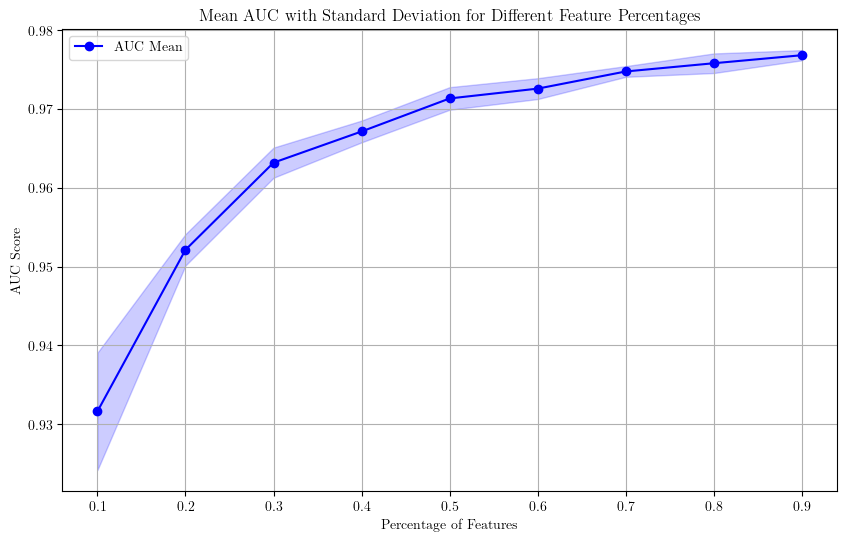

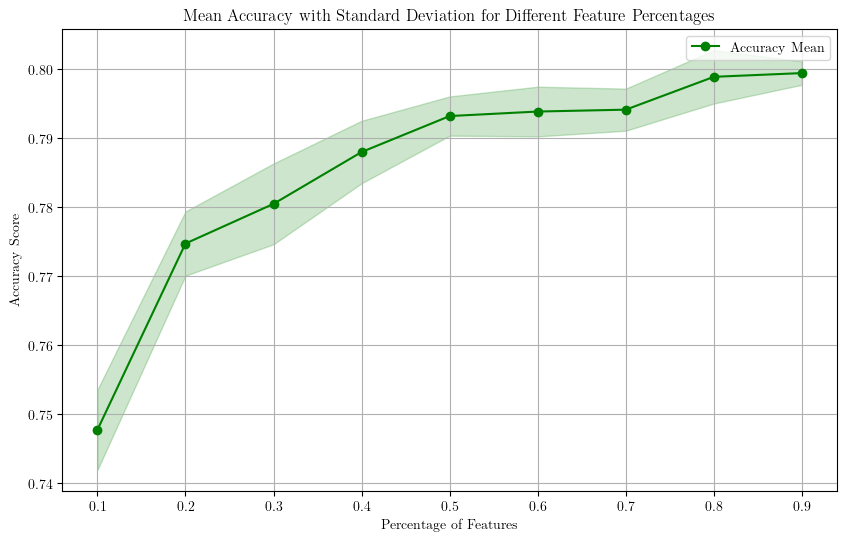

In [22]:
# Plotting AUC results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(feature_percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(feature_percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0.2)  # Adjusted transparency for AUC Std
plt.xlabel('Percentage of Features')
plt.ylabel('AUC Score')
plt.title('Mean AUC with Standard Deviation for Different Feature Percentages')
plt.grid(True)
plt.legend()

# Plotting Accuracy results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(feature_percentages, test_accuracy_acc_mean, label='Accuracy Mean', color='green', marker='o')
plt.fill_between(feature_percentages, 
                 np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std),
                 np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std),
                 color='green', alpha=0.2)  # Adjusted transparency for Accuracy Std
plt.xlabel('Percentage of Features')
plt.ylabel('Accuracy Score')
plt.title('Mean Accuracy with Standard Deviation for Different Feature Percentages')
plt.grid(True)
plt.legend()


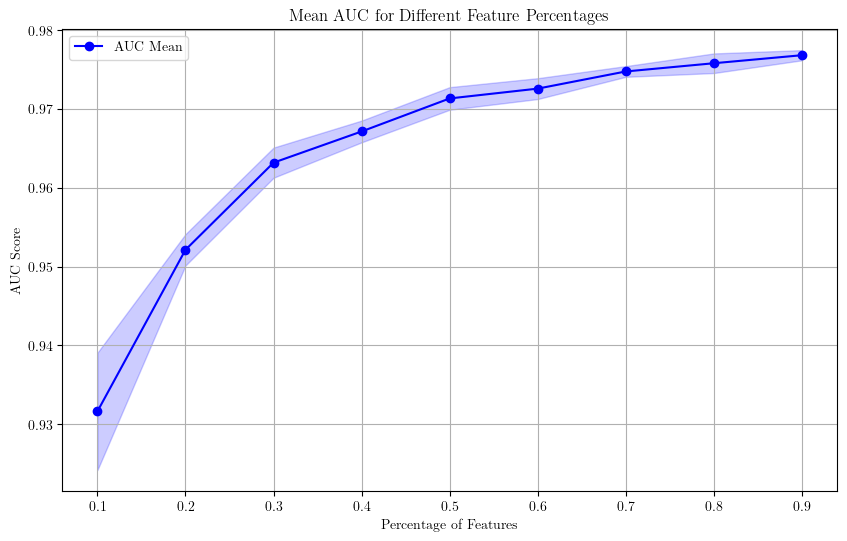

In [21]:
# Plotting AUC results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(feature_percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(feature_percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0.2)  # Adjusted transparency for AUC Std
plt.xlabel('Percentage of Features')
plt.ylabel('AUC Score')
plt.title('Mean AUC for Different Feature Percentages')
plt.grid(True)
plt.legend()

## Heat Map: Number of Channels

In [18]:
def evaluate_model(hidden_channels, out_channels, epochs=800, corrupt=False, corrupt_percentage=0.1):
    # Initialize the model
    model = Net(dataset.num_features, hidden_channels, out_channels).to(device)

    # Set up the optimizer and loss function
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Initialize the trainer with the model, optimizer, and criterion
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and evaluate
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=epochs,
        early_stopping=True,
        early_stopping_patience=200,
    )
    
    best_model = Net(dataset.num_features, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)

    # Return detailed results
    return final_test_auc, final_test_acc

In [19]:
# Download the dataset and apply the transformation
dataset = Planetoid("./nets/", name='PubMed', transform=transform)

# Get the training, validation and test data
train_data, val_data, test_data = dataset[0]

hidden_units = [8, 16, 32, 64, 128, 256]
output_units = [4, 8, 16, 32, 64, 128]

results_matrix = np.zeros((len(hidden_units), len(output_units)))


for i, hidden in enumerate(hidden_units):
    for j, output in enumerate(output_units):
        auc, _ = evaluate_model(hidden, output)
        results_matrix[i, j] = auc
        print(f"Hidden units: {hidden}, Output units: {output} -> AUC: {auc:.4f}")

 52%|█████▏    | 416/800 [00:17<00:16, 23.48it/s]


Early stopping at epoch 417.
Hidden units: 8, Output units: 4 -> AUC: 0.9488


 42%|████▏     | 333/800 [00:15<00:21, 22.13it/s]


Early stopping at epoch 334.
Hidden units: 8, Output units: 8 -> AUC: 0.9555


 50%|████▉     | 397/800 [00:18<00:18, 21.96it/s]


Early stopping at epoch 398.
Hidden units: 8, Output units: 16 -> AUC: 0.9525


 81%|████████  | 649/800 [00:28<00:06, 23.09it/s]


Early stopping at epoch 650.
Hidden units: 8, Output units: 32 -> AUC: 0.9522


 76%|███████▌  | 607/800 [00:27<00:08, 21.78it/s]


Early stopping at epoch 608.
Hidden units: 8, Output units: 64 -> AUC: 0.9453


100%|██████████| 800/800 [00:39<00:00, 20.33it/s]


Total training time: 34.9006 seconds.
Total validation time: 4.2738 seconds.
Hidden units: 8, Output units: 128 -> AUC: 0.9361


 32%|███▏      | 256/800 [00:10<00:23, 23.63it/s]


Early stopping at epoch 257.
Hidden units: 16, Output units: 4 -> AUC: 0.9504


 32%|███▎      | 260/800 [00:11<00:23, 23.30it/s]


Early stopping at epoch 261.
Hidden units: 16, Output units: 8 -> AUC: 0.9616


 44%|████▎     | 348/800 [00:15<00:20, 22.37it/s]


Early stopping at epoch 349.
Hidden units: 16, Output units: 16 -> AUC: 0.9641


 57%|█████▋    | 457/800 [00:20<00:15, 22.23it/s]


Early stopping at epoch 458.
Hidden units: 16, Output units: 32 -> AUC: 0.9629


 56%|█████▌    | 445/800 [00:20<00:16, 21.92it/s]


Early stopping at epoch 446.
Hidden units: 16, Output units: 64 -> AUC: 0.9590


 77%|███████▋  | 616/800 [00:30<00:09, 20.30it/s]


Early stopping at epoch 617.
Hidden units: 16, Output units: 128 -> AUC: 0.9533


 33%|███▎      | 266/800 [00:11<00:23, 22.26it/s]


Early stopping at epoch 267.
Hidden units: 32, Output units: 4 -> AUC: 0.9546


 36%|███▌      | 285/800 [00:13<00:24, 20.91it/s]


Early stopping at epoch 286.
Hidden units: 32, Output units: 8 -> AUC: 0.9660


 42%|████▏     | 336/800 [00:16<00:22, 20.76it/s]


Early stopping at epoch 337.
Hidden units: 32, Output units: 16 -> AUC: 0.9676


 63%|██████▎   | 505/800 [00:24<00:14, 20.49it/s]


Early stopping at epoch 506.
Hidden units: 32, Output units: 32 -> AUC: 0.9702


 60%|█████▉    | 478/800 [00:23<00:16, 20.05it/s]


Early stopping at epoch 479.
Hidden units: 32, Output units: 64 -> AUC: 0.9694


 66%|██████▌   | 529/800 [00:26<00:13, 20.19it/s]


Early stopping at epoch 530.
Hidden units: 32, Output units: 128 -> AUC: 0.9650


 48%|████▊     | 382/800 [00:17<00:19, 21.38it/s]


Early stopping at epoch 383.
Hidden units: 64, Output units: 4 -> AUC: 0.9535


 32%|███▏      | 254/800 [00:12<00:26, 20.41it/s]


Early stopping at epoch 255.
Hidden units: 64, Output units: 8 -> AUC: 0.9665


 36%|███▌      | 285/800 [00:14<00:25, 20.02it/s]


Early stopping at epoch 286.
Hidden units: 64, Output units: 16 -> AUC: 0.9686


 50%|█████     | 403/800 [00:19<00:19, 20.87it/s]


Early stopping at epoch 404.
Hidden units: 64, Output units: 32 -> AUC: 0.9713


 42%|████▏     | 336/800 [00:16<00:23, 19.94it/s]


Early stopping at epoch 337.
Hidden units: 64, Output units: 64 -> AUC: 0.9711


 76%|███████▌  | 605/800 [00:30<00:09, 19.87it/s]


Early stopping at epoch 606.
Hidden units: 64, Output units: 128 -> AUC: 0.9740


 36%|███▌      | 288/800 [00:14<00:25, 19.97it/s]


Early stopping at epoch 289.
Hidden units: 128, Output units: 4 -> AUC: 0.9555


 35%|███▌      | 281/800 [00:13<00:25, 20.25it/s]


Early stopping at epoch 282.
Hidden units: 128, Output units: 8 -> AUC: 0.9660


 48%|████▊     | 388/800 [00:19<00:20, 20.20it/s]


Early stopping at epoch 389.
Hidden units: 128, Output units: 16 -> AUC: 0.9713


 42%|████▏     | 337/800 [00:16<00:22, 20.15it/s]


Early stopping at epoch 338.
Hidden units: 128, Output units: 32 -> AUC: 0.9719


 46%|████▌     | 367/800 [00:18<00:21, 19.74it/s]


Early stopping at epoch 368.
Hidden units: 128, Output units: 64 -> AUC: 0.9755


 53%|█████▎    | 423/800 [00:21<00:19, 19.61it/s]


Early stopping at epoch 424.
Hidden units: 128, Output units: 128 -> AUC: 0.9741


 37%|███▋      | 296/800 [00:15<00:25, 19.40it/s]


Early stopping at epoch 297.
Hidden units: 256, Output units: 4 -> AUC: 0.9539


 35%|███▌      | 281/800 [00:14<00:26, 19.26it/s]


Early stopping at epoch 282.
Hidden units: 256, Output units: 8 -> AUC: 0.9662


 38%|███▊      | 300/800 [00:15<00:25, 19.34it/s]


Early stopping at epoch 301.
Hidden units: 256, Output units: 16 -> AUC: 0.9702


 39%|███▉      | 312/800 [00:16<00:25, 18.95it/s]


Early stopping at epoch 313.
Hidden units: 256, Output units: 32 -> AUC: 0.9743


 46%|████▌     | 365/800 [00:19<00:23, 18.35it/s]


Early stopping at epoch 366.
Hidden units: 256, Output units: 64 -> AUC: 0.9772


 50%|█████     | 403/800 [00:23<00:22, 17.35it/s]

Early stopping at epoch 404.
Hidden units: 256, Output units: 128 -> AUC: 0.9765


Text(0.5, 1.0, 'AUC for different configurations of Hidden and Output Units')

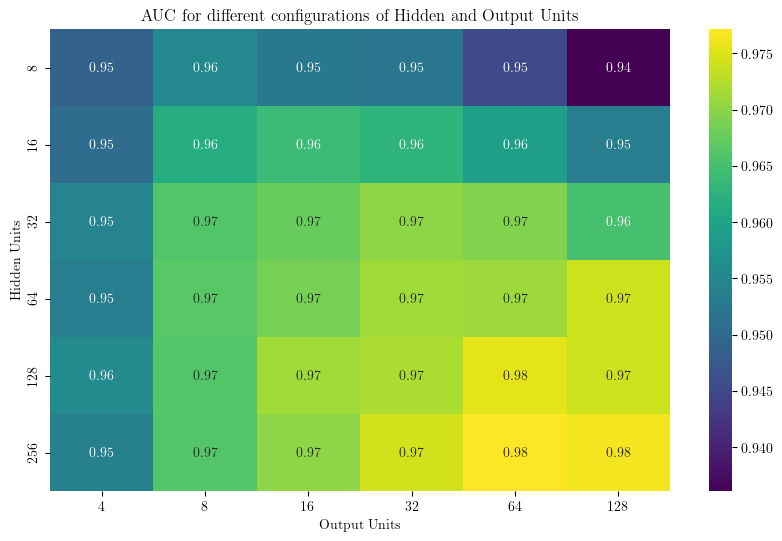

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_matrix, annot=True, xticklabels=output_units, yticklabels=hidden_units, cmap='viridis')
plt.xlabel('Output Units')
plt.ylabel('Hidden Units')
plt.title('AUC for different configurations of Hidden and Output Units')

## Heat Map: Learning Rate

In [26]:
# Function to evaluate the model with a given learning rate using the trainer class
def evaluate_model(learning_rate):
    hidden_channels = 64
    out_channels = 32
    model = Net(dataset.num_features, hidden_channels, out_channels).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # Initialize the trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and get evaluation results# Assicurati di passare g_val e g_test alla funzione train_model
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=800,
        early_stopping=True,
        early_stopping_patience=100,
    )

    best_model = Net(dataset.num_features, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data)
    

    return final_test_auc, final_test_acc 

In [27]:
# Define learning rates to evaluate
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
results_matrix = np.zeros((len(learning_rates), 2)) 

# Evaluate the model for different learning rates
for i, lr in enumerate(learning_rates):
    auc, acc = evaluate_model(lr)
    results_matrix[i, 0] = auc  # AUC
    results_matrix[i, 1] = acc  # Accuracy
    print(f"Learning rate: {lr} -> AUC: {auc:.4f}, Accuracy: {acc:.4f}")

 62%|██████▎   | 500/800 [00:22<00:13, 21.85it/s]


Early stopping at epoch 501.
Learning rate: 0.001 -> AUC: 0.9490, Accuracy: 0.7780


 31%|███       | 247/800 [00:12<00:27, 20.06it/s]


Early stopping at epoch 248.
Learning rate: 0.01 -> AUC: 0.9727, Accuracy: 0.8019


 29%|██▉       | 230/800 [00:11<00:27, 20.65it/s]


Early stopping at epoch 231.
Learning rate: 0.1 -> AUC: 0.9681, Accuracy: 0.7263


 21%|██▏       | 171/800 [00:07<00:29, 21.40it/s]


Early stopping at epoch 172.
Learning rate: 0.5 -> AUC: 0.9426, Accuracy: 0.6922


 22%|██▏       | 177/800 [00:08<00:30, 20.25it/s]

Early stopping at epoch 178.
Learning rate: 1 -> AUC: 0.8726, Accuracy: 0.6403


Text(122.42267123557924, 0.5, 'Learning Rate')

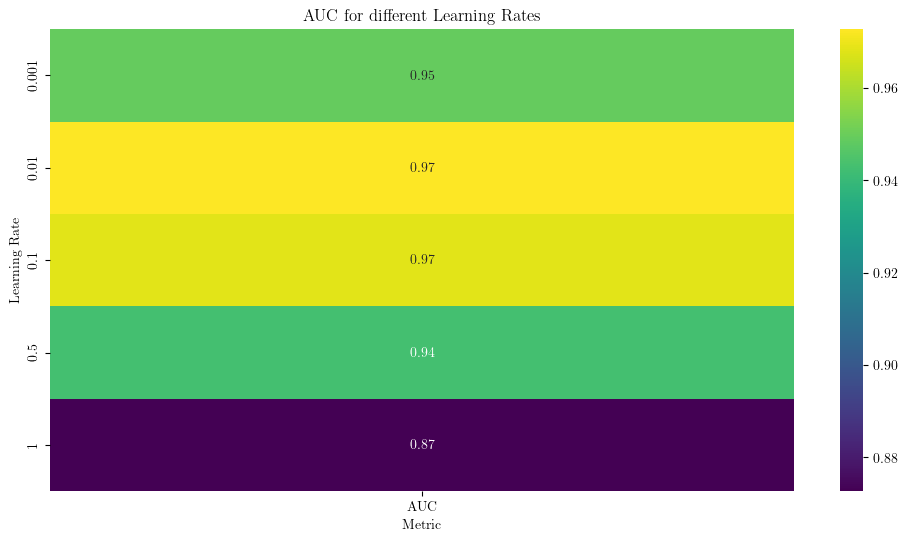

In [28]:
# Plot AUC results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 0].reshape(-1, 1), annot=True, xticklabels=['AUC'], yticklabels=learning_rates, cmap='viridis')
plt.title('AUC for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')

Text(122.42267123557924, 0.5, 'Learning Rate')

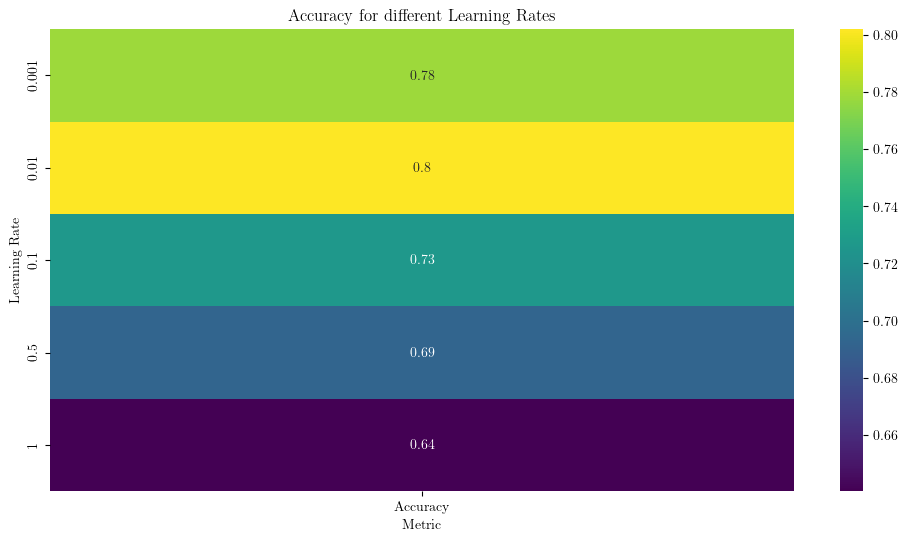

In [29]:
# Plot Accuracy results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 1].reshape(-1, 1), annot=True, xticklabels=['Accuracy'], yticklabels=learning_rates, cmap='viridis')
plt.title('Accuracy for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')

## Map for dropout

In [34]:
# Function to evaluate the model with a given learning rate using the trainer class
def evaluate_model(dropout):
    hidden_channels = 64
    out_channels = 32
    model = Net(dataset.num_features, hidden_channels, out_channels, dropout=dropout).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    # Initialize the trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and get evaluation results# Assicurati di passare g_val e g_test alla funzione train_model
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=800,
        early_stopping=True,
        early_stopping_patience=200
    )

    best_model = Net(dataset.num_features, hidden_channels, out_channels, dropout).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data)
    

    return final_test_auc, final_test_acc

In [35]:
dropout_rates = np.linspace(0.1, 0.7, 7)
values = {"Dropout": {}}  

for i in range(10):
    for dropout in dropout_rates:
        if dropout not in values["Dropout"]:
            values["Dropout"][dropout] = {"AUC": [], "Accuracy": []}
        
        auc, acc = evaluate_model(dropout)
        
        values["Dropout"][dropout]["AUC"].append(auc)
        values["Dropout"][dropout]["Accuracy"].append(acc)

for dropout in values["Dropout"]:
    auc_values = values["Dropout"][dropout]["AUC"]
    acc_values = values["Dropout"][dropout]["Accuracy"]
    
    values["Dropout"][dropout]["MeanAUC"] = np.mean(auc_values)
    values["Dropout"][dropout]["MeanAcc"] = np.mean(acc_values)
    values["Dropout"][dropout]["StdAUC"] = np.std(auc_values)
    values["Dropout"][dropout]["StdAcc"] = np.std(acc_values)

import pprint
pprint.pprint(values)


 46%|████▋     | 370/800 [00:17<00:19, 21.75it/s]


Early stopping at epoch 371.


 46%|████▌     | 368/800 [00:16<00:19, 22.01it/s]


Early stopping at epoch 369.


 48%|████▊     | 383/800 [00:18<00:19, 20.88it/s]


Early stopping at epoch 384.


 56%|█████▌    | 444/800 [00:21<00:17, 20.87it/s]


Early stopping at epoch 445.


 39%|███▉      | 312/800 [00:15<00:24, 20.19it/s]


Early stopping at epoch 313.


 42%|████▏     | 337/800 [00:16<00:23, 19.99it/s]


Early stopping at epoch 338.


 48%|████▊     | 386/800 [00:19<00:20, 20.09it/s]


Early stopping at epoch 387.


 42%|████▏     | 332/800 [00:16<00:23, 20.11it/s]


Early stopping at epoch 333.


 49%|████▊     | 389/800 [00:19<00:20, 20.01it/s]


Early stopping at epoch 390.


 44%|████▍     | 354/800 [00:17<00:22, 20.15it/s]


Early stopping at epoch 355.


 47%|████▋     | 373/800 [00:18<00:21, 19.96it/s]


Early stopping at epoch 374.


 50%|█████     | 401/800 [00:20<00:20, 19.94it/s]


Early stopping at epoch 402.


 41%|████      | 326/800 [00:16<00:23, 19.95it/s]


Early stopping at epoch 327.


 60%|█████▉    | 479/800 [00:23<00:16, 19.99it/s]


Early stopping at epoch 480.


 40%|████      | 320/800 [00:16<00:24, 19.93it/s]


Early stopping at epoch 321.


 46%|████▌     | 364/800 [00:17<00:20, 20.77it/s]


Early stopping at epoch 365.


 52%|█████▏    | 412/800 [00:20<00:19, 20.25it/s]


Early stopping at epoch 413.


 46%|████▌     | 365/800 [00:18<00:21, 19.94it/s]


Early stopping at epoch 366.


 46%|████▌     | 366/800 [00:18<00:21, 20.06it/s]


Early stopping at epoch 367.


 43%|████▎     | 341/800 [00:17<00:22, 20.01it/s]


Early stopping at epoch 342.


 40%|███▉      | 317/800 [00:14<00:22, 21.52it/s]


Early stopping at epoch 318.


 50%|█████     | 403/800 [00:19<00:19, 20.57it/s]


Early stopping at epoch 404.


 47%|████▋     | 377/800 [00:18<00:21, 20.05it/s]


Early stopping at epoch 378.


 52%|█████▏    | 418/800 [00:20<00:19, 20.07it/s]


Early stopping at epoch 419.


 47%|████▋     | 377/800 [00:18<00:21, 19.99it/s]


Early stopping at epoch 378.


 44%|████▎     | 349/800 [00:17<00:22, 20.03it/s]


Early stopping at epoch 350.


 43%|████▎     | 343/800 [00:16<00:21, 20.78it/s]


Early stopping at epoch 344.


 50%|████▉     | 397/800 [00:19<00:19, 20.56it/s]


Early stopping at epoch 398.


 46%|████▋     | 370/800 [00:17<00:20, 21.44it/s]


Early stopping at epoch 371.


 41%|████▏     | 331/800 [00:15<00:22, 20.98it/s]


Early stopping at epoch 332.


 41%|████      | 329/800 [00:16<00:23, 20.34it/s]


Early stopping at epoch 330.


 52%|█████▎    | 420/800 [00:20<00:18, 20.15it/s]


Early stopping at epoch 421.


 50%|████▉     | 398/800 [00:19<00:20, 20.00it/s]


Early stopping at epoch 399.


 46%|████▋     | 371/800 [00:18<00:21, 20.16it/s]


Early stopping at epoch 372.


 39%|███▉      | 314/800 [00:15<00:23, 20.76it/s]


Early stopping at epoch 315.


 44%|████▎     | 349/800 [00:17<00:22, 20.49it/s]


Early stopping at epoch 350.


 46%|████▌     | 364/800 [00:18<00:21, 20.19it/s]


Early stopping at epoch 365.


 61%|██████    | 489/800 [00:23<00:15, 20.48it/s]


Early stopping at epoch 490.


 42%|████▏     | 332/800 [00:16<00:22, 20.66it/s]


Early stopping at epoch 333.


 40%|████      | 322/800 [00:15<00:22, 20.79it/s]


Early stopping at epoch 323.


 48%|████▊     | 384/800 [00:18<00:20, 20.69it/s]


Early stopping at epoch 385.


 44%|████▎     | 348/800 [00:16<00:21, 20.62it/s]


Early stopping at epoch 349.


 58%|█████▊    | 463/800 [00:22<00:16, 20.59it/s]


Early stopping at epoch 464.


 38%|███▊      | 303/800 [00:14<00:24, 20.29it/s]


Early stopping at epoch 304.


 63%|██████▎   | 505/800 [00:24<00:14, 20.50it/s]


Early stopping at epoch 506.


 46%|████▋     | 371/800 [00:17<00:20, 20.89it/s]


Early stopping at epoch 372.


 44%|████▍     | 353/800 [00:17<00:21, 20.42it/s]


Early stopping at epoch 354.


 40%|████      | 324/800 [00:15<00:23, 20.68it/s]


Early stopping at epoch 325.


 53%|█████▎    | 421/800 [00:20<00:18, 20.61it/s]


Early stopping at epoch 422.


 41%|████▏     | 330/800 [00:15<00:22, 20.74it/s]


Early stopping at epoch 331.


 53%|█████▎    | 421/800 [00:20<00:18, 20.23it/s]


Early stopping at epoch 422.


 40%|████      | 321/800 [00:15<00:23, 20.39it/s]


Early stopping at epoch 322.


 42%|████▏     | 339/800 [00:16<00:22, 20.26it/s]


Early stopping at epoch 340.


 41%|████      | 326/800 [00:15<00:23, 20.38it/s]


Early stopping at epoch 327.


 63%|██████▎   | 505/800 [00:24<00:14, 20.63it/s]


Early stopping at epoch 506.


 44%|████▍     | 355/800 [00:17<00:21, 20.39it/s]


Early stopping at epoch 356.


 44%|████▎     | 348/800 [00:16<00:22, 20.51it/s]


Early stopping at epoch 349.


 43%|████▎     | 347/800 [00:16<00:22, 20.57it/s]


Early stopping at epoch 348.


 47%|████▋     | 376/800 [00:18<00:20, 20.66it/s]


Early stopping at epoch 377.


 57%|█████▋    | 456/800 [00:21<00:16, 21.05it/s]


Early stopping at epoch 457.


 50%|█████     | 401/800 [00:20<00:19, 20.02it/s]


Early stopping at epoch 402.


 51%|█████▏    | 411/800 [00:20<00:19, 20.04it/s]


Early stopping at epoch 412.


 43%|████▎     | 344/800 [00:17<00:22, 19.94it/s]


Early stopping at epoch 345.


 48%|████▊     | 383/800 [00:19<00:20, 19.96it/s]


Early stopping at epoch 384.


 44%|████▍     | 356/800 [00:17<00:22, 20.03it/s]


Early stopping at epoch 357.


 40%|████      | 321/800 [00:16<00:24, 19.95it/s]


Early stopping at epoch 322.


 43%|████▎     | 341/800 [00:17<00:22, 19.99it/s]


Early stopping at epoch 342.


 42%|████▏     | 336/800 [00:16<00:23, 20.08it/s]


Early stopping at epoch 337.


 39%|███▉      | 311/800 [00:15<00:24, 19.98it/s]


Early stopping at epoch 312.


 46%|████▋     | 370/800 [00:18<00:21, 19.99it/s]

Early stopping at epoch 371.
{'Dropout': {0.1: {'AUC': [0.9691002587027071,
                           0.9672328910842055,
                           0.9665061042760885,
                           0.9676088082732734,
                           0.9684787531441829,
                           0.9686496060811427,
                           0.9662690687354194,
                           0.9654809866543288,
                           0.9665280972643981,
                           0.9668294826597504],
                   'Accuracy': [0.7678249097472925,
                                0.7736913357400722,
                                0.7714350180505415,
                                0.7443592057761733,
                                0.7603790613718412,
                                0.7612815884476535,
                                0.7581227436823105,
                                0.7603790613718412,
                                0.7696299638989169,
                                

In [36]:
print("Mean AUC and Accuracy for different dropout rates:")
for dropout, metrics in values["Dropout"].items():
    print(f"Dropout {dropout}: Mean AUC = {metrics['MeanAUC']}, Mean Accuracy = {metrics['MeanAcc']}")
    print(f"Dropout {dropout}: Std AUC = {metrics['StdAUC']}, Std Accuracy = {metrics['StdAcc']}")

Mean AUC and Accuracy for different dropout rates:
Dropout 0.1: Mean AUC = 0.9672684056875497, Mean Accuracy = 0.7632445848375451
Dropout 0.1: Std AUC = 0.0011117927298489561, Std Accuracy = 0.008034550551272987
Dropout 0.2: Mean AUC = 0.969703406225156, Mean Accuracy = 0.7754512635379062
Dropout 0.2: Std AUC = 0.001749475934862635, Std Accuracy = 0.004496586986826744
Dropout 0.3: Mean AUC = 0.9712016887356801, Mean Accuracy = 0.7802797833935019
Dropout 0.3: Std AUC = 0.0011354202869279907, Std Accuracy = 0.004837999736168977
Dropout 0.4: Mean AUC = 0.9722493898982132, Mean Accuracy = 0.7842283393501804
Dropout 0.4: Std AUC = 0.0014473408290833314, Std Accuracy = 0.004982376587272589
Dropout 0.5: Mean AUC = 0.9721193359909552, Mean Accuracy = 0.7935920577617328
Dropout 0.5: Std AUC = 0.0007455120698352884, Std Accuracy = 0.004184602579402251
Dropout 0.6: Mean AUC = 0.9709294135040206, Mean Accuracy = 0.7914259927797833
Dropout 0.6: Std AUC = 0.0008540797904499474, Std Accuracy = 0.0039

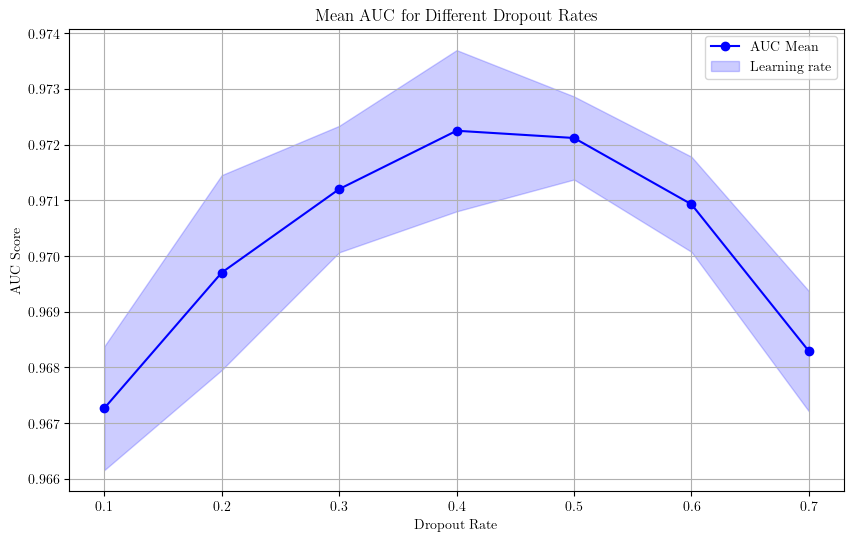

In [39]:
dropout_rates = list(values["Dropout"].keys())
test_accuracy_auc_mean = [np.mean(values["Dropout"][dropout]["AUC"]) for dropout in dropout_rates]
test_accuracy_auc_std = [np.std(values["Dropout"][dropout]["AUC"]) for dropout in dropout_rates]
test_accuracy_acc_mean = [np.mean(values["Dropout"][dropout]["Accuracy"]) for dropout in dropout_rates]
test_accuracy_acc_std = [np.std(values["Dropout"][dropout]["Accuracy"]) for dropout in dropout_rates]

# Plotting AUC results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(dropout_rates, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', label="Learning rate", alpha=0.2)  # Area di deviazione standard per AUC
plt.xlabel('Dropout Rate')
plt.ylabel('AUC Score')
plt.title('Mean AUC for Different Dropout Rates')
plt.grid(True)
plt.legend()
plt.show()

#